# PyTorch GAN - MNIST

In [25]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [65]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [66]:
from utils import Logger

from python_utils.logger import Logged

ImportError: cannot import name 'Logger'

In [30]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

Processing...
Done!


In [31]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [32]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

discriminator = DiscriminatorNet()

In [33]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

generator = GeneratorNet()

In [34]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [35]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

loss = nn.BCELoss()

In [36]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [37]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [38]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [39]:
num_test_samples = 16
test_noise = noise(num_test_samples)

Epoch:  1


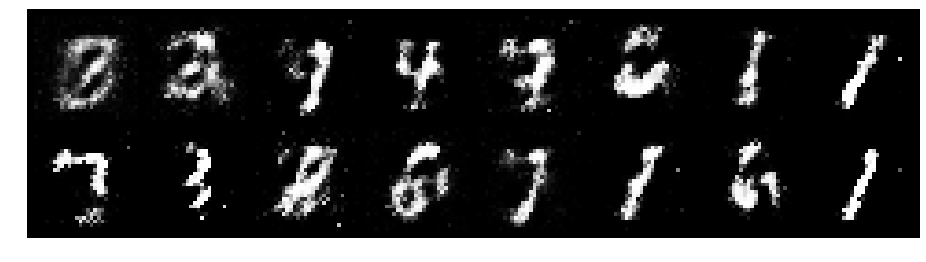

Epoch: [0/20], Batch Num: [0/600]
Discriminator Loss: 0.7637, Generator Loss: 2.5073
D(x): 0.7899, D(G(z)): 0.2726


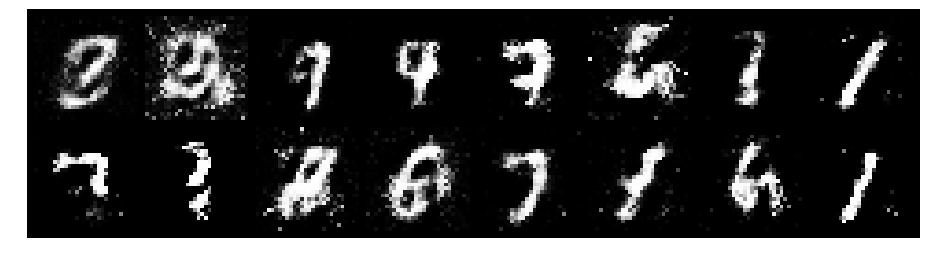

Epoch: [0/20], Batch Num: [100/600]
Discriminator Loss: 0.7086, Generator Loss: 1.4987
D(x): 0.7942, D(G(z)): 0.3104


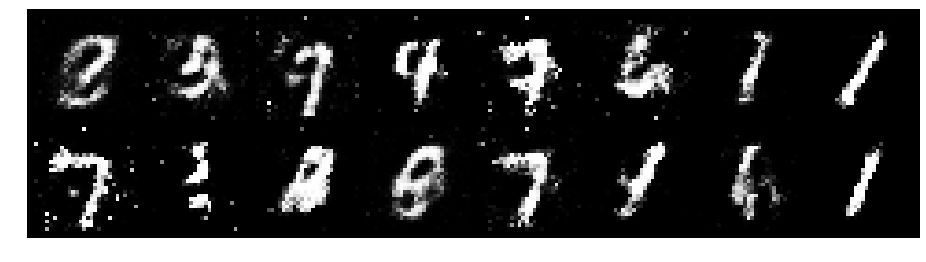

Epoch: [0/20], Batch Num: [200/600]
Discriminator Loss: 0.8336, Generator Loss: 2.1118
D(x): 0.7481, D(G(z)): 0.2802


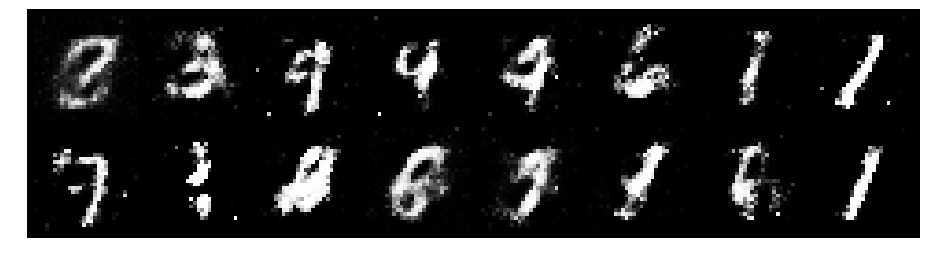

Epoch: [0/20], Batch Num: [300/600]
Discriminator Loss: 0.8775, Generator Loss: 1.5314
D(x): 0.6639, D(G(z)): 0.2463


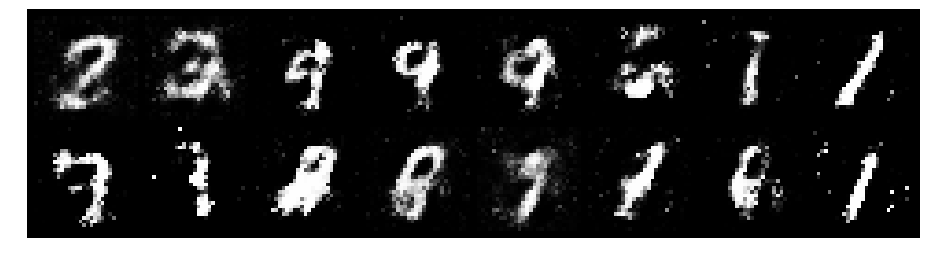

Epoch: [0/20], Batch Num: [400/600]
Discriminator Loss: 0.8811, Generator Loss: 1.6289
D(x): 0.7041, D(G(z)): 0.2839


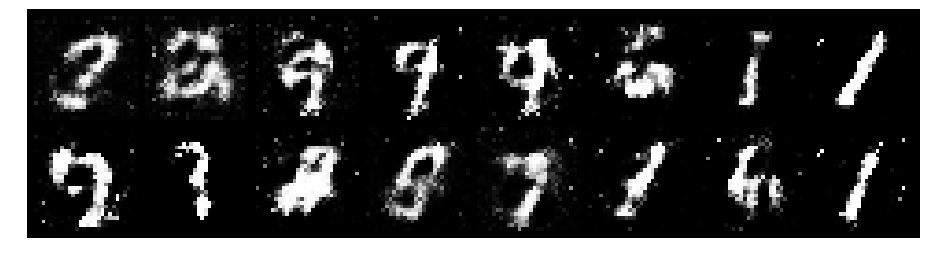

Epoch: [0/20], Batch Num: [500/600]
Discriminator Loss: 0.7056, Generator Loss: 2.1396
D(x): 0.7559, D(G(z)): 0.2350
Epoch:  2


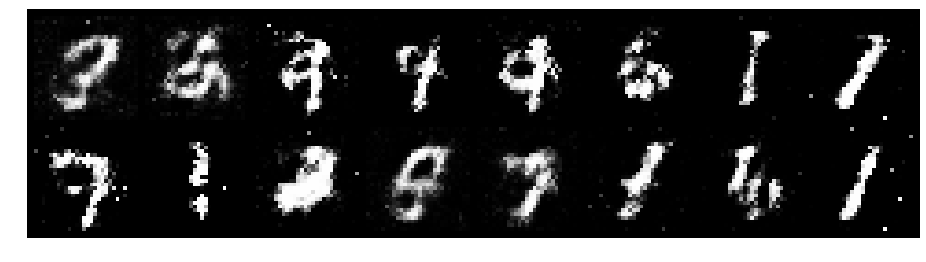

Epoch: [1/20], Batch Num: [0/600]
Discriminator Loss: 0.9091, Generator Loss: 1.7457
D(x): 0.7808, D(G(z)): 0.3551


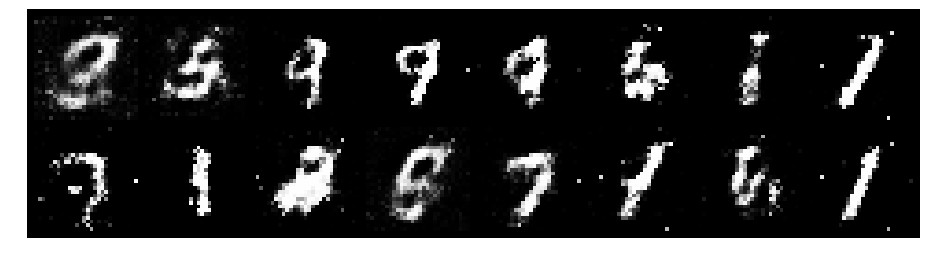

Epoch: [1/20], Batch Num: [100/600]
Discriminator Loss: 0.7342, Generator Loss: 1.8004
D(x): 0.7303, D(G(z)): 0.2439


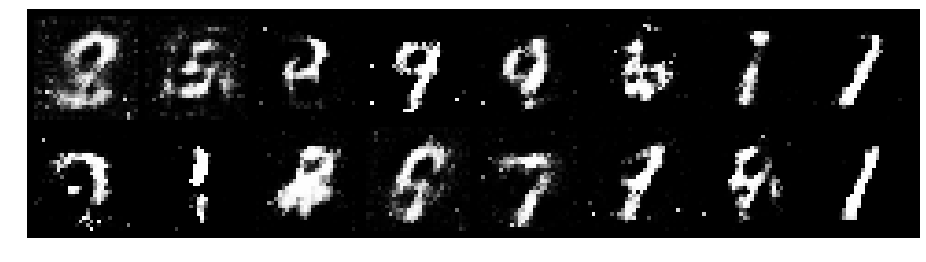

Epoch: [1/20], Batch Num: [200/600]
Discriminator Loss: 0.7812, Generator Loss: 1.7484
D(x): 0.7533, D(G(z)): 0.2873


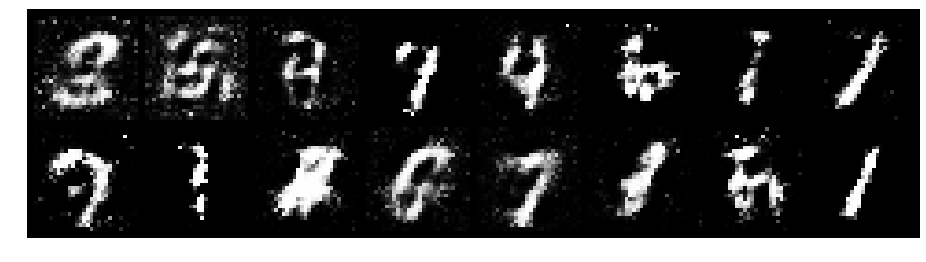

Epoch: [1/20], Batch Num: [300/600]
Discriminator Loss: 0.8127, Generator Loss: 1.7763
D(x): 0.6963, D(G(z)): 0.2241


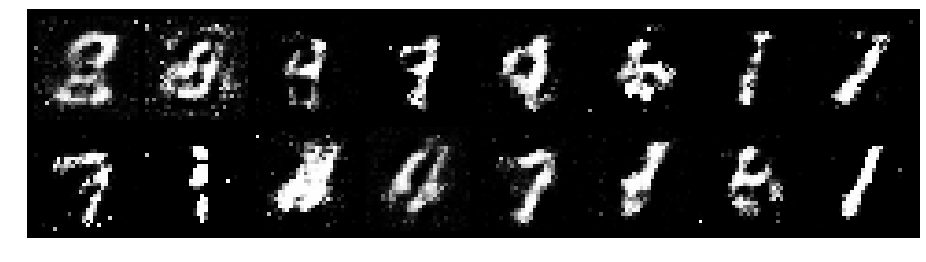

Epoch: [1/20], Batch Num: [400/600]
Discriminator Loss: 0.9424, Generator Loss: 1.5256
D(x): 0.6491, D(G(z)): 0.2131


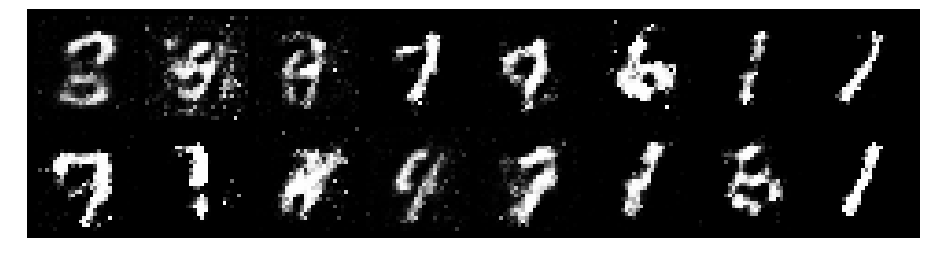

Epoch: [1/20], Batch Num: [500/600]
Discriminator Loss: 0.8814, Generator Loss: 1.4991
D(x): 0.7175, D(G(z)): 0.2742
Epoch:  3


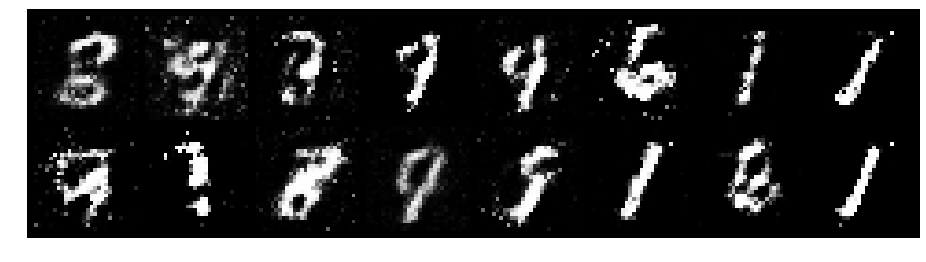

Epoch: [2/20], Batch Num: [0/600]
Discriminator Loss: 0.6776, Generator Loss: 1.8913
D(x): 0.7394, D(G(z)): 0.2077


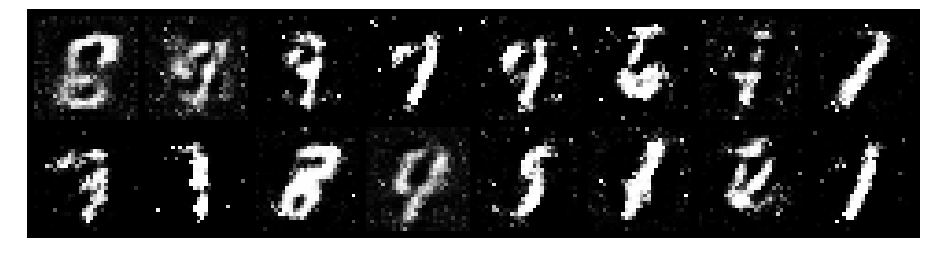

Epoch: [2/20], Batch Num: [100/600]
Discriminator Loss: 1.0556, Generator Loss: 1.8256
D(x): 0.6946, D(G(z)): 0.3239


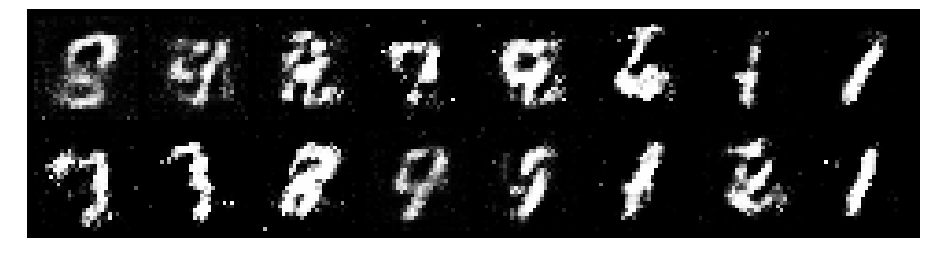

Epoch: [2/20], Batch Num: [200/600]
Discriminator Loss: 0.7645, Generator Loss: 2.1637
D(x): 0.7607, D(G(z)): 0.2416


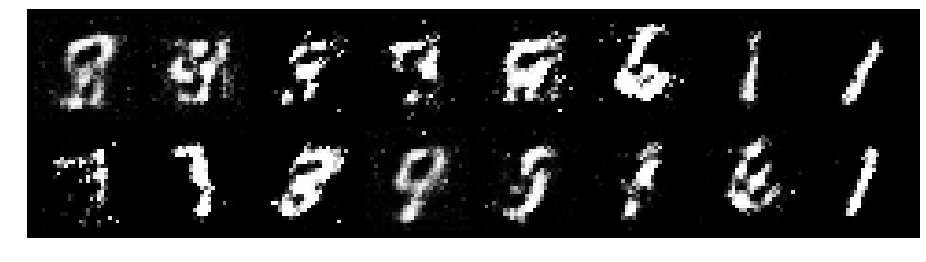

Epoch: [2/20], Batch Num: [300/600]
Discriminator Loss: 0.8835, Generator Loss: 2.2328
D(x): 0.6531, D(G(z)): 0.1950


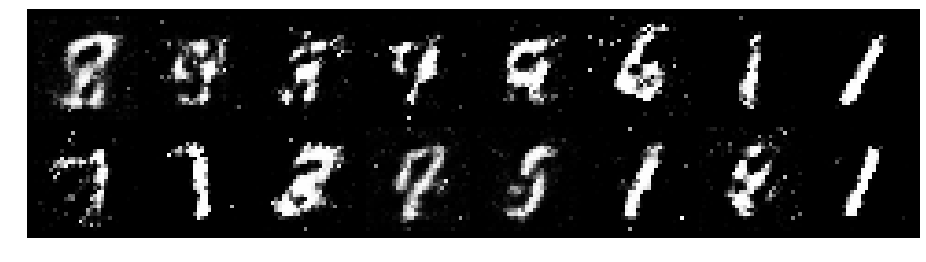

Epoch: [2/20], Batch Num: [400/600]
Discriminator Loss: 0.9186, Generator Loss: 1.6840
D(x): 0.6544, D(G(z)): 0.2899


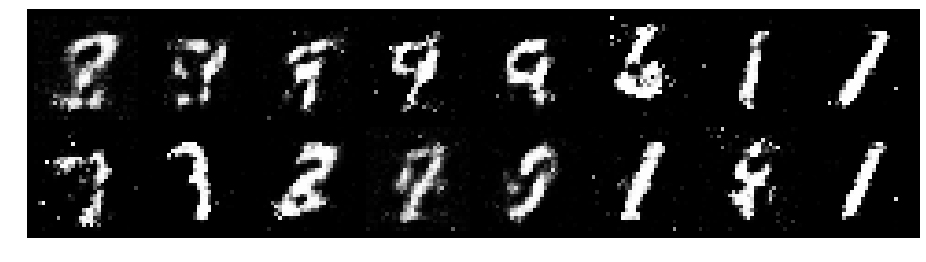

Epoch: [2/20], Batch Num: [500/600]
Discriminator Loss: 0.9419, Generator Loss: 2.0281
D(x): 0.7193, D(G(z)): 0.2617
Epoch:  4


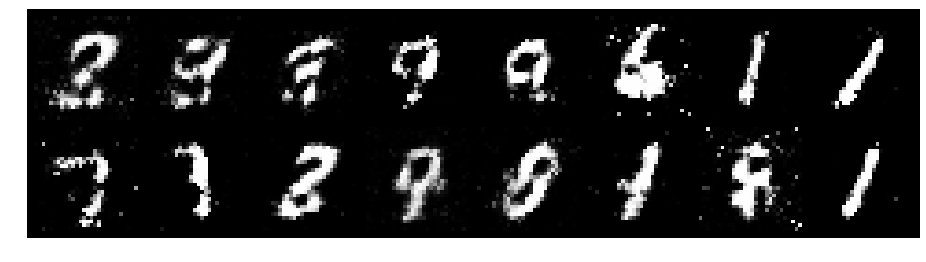

Epoch: [3/20], Batch Num: [0/600]
Discriminator Loss: 0.9888, Generator Loss: 1.5085
D(x): 0.7064, D(G(z)): 0.3225


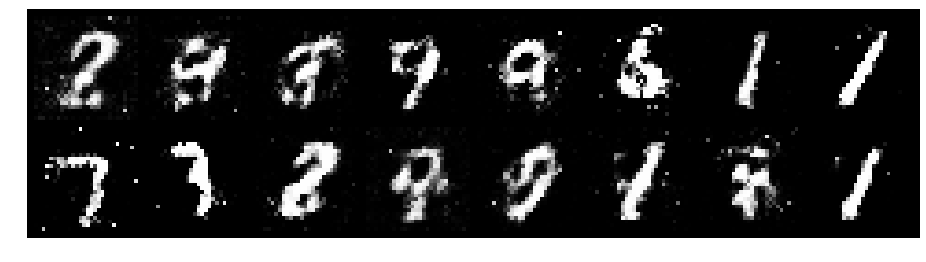

Epoch: [3/20], Batch Num: [100/600]
Discriminator Loss: 1.0470, Generator Loss: 1.4626
D(x): 0.7276, D(G(z)): 0.3683


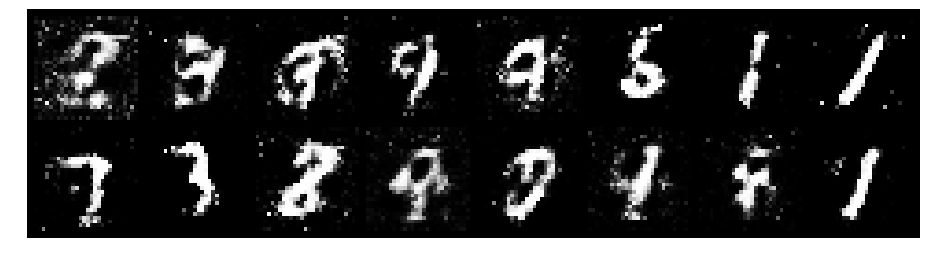

Epoch: [3/20], Batch Num: [200/600]
Discriminator Loss: 0.7362, Generator Loss: 1.7107
D(x): 0.7779, D(G(z)): 0.2830


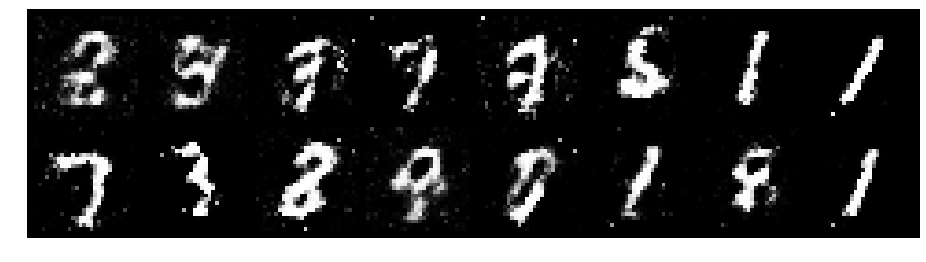

Epoch: [3/20], Batch Num: [300/600]
Discriminator Loss: 0.9103, Generator Loss: 1.5194
D(x): 0.7136, D(G(z)): 0.2676


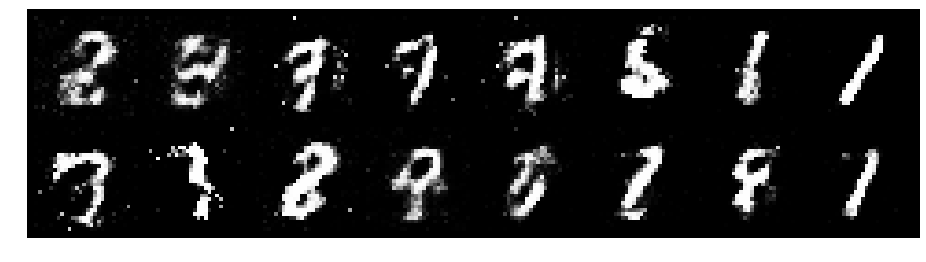

Epoch: [3/20], Batch Num: [400/600]
Discriminator Loss: 0.7926, Generator Loss: 1.4745
D(x): 0.7226, D(G(z)): 0.2691


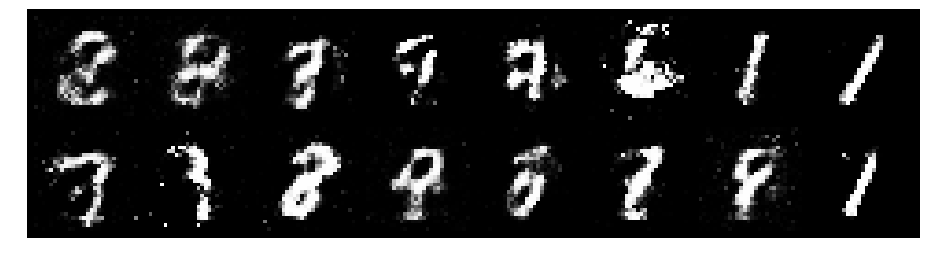

Epoch: [3/20], Batch Num: [500/600]
Discriminator Loss: 1.0508, Generator Loss: 1.3989
D(x): 0.6308, D(G(z)): 0.3394
Epoch:  5


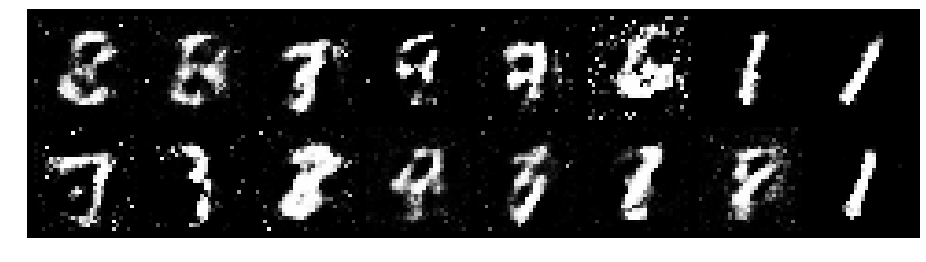

Epoch: [4/20], Batch Num: [0/600]
Discriminator Loss: 1.0484, Generator Loss: 1.2942
D(x): 0.6520, D(G(z)): 0.3525


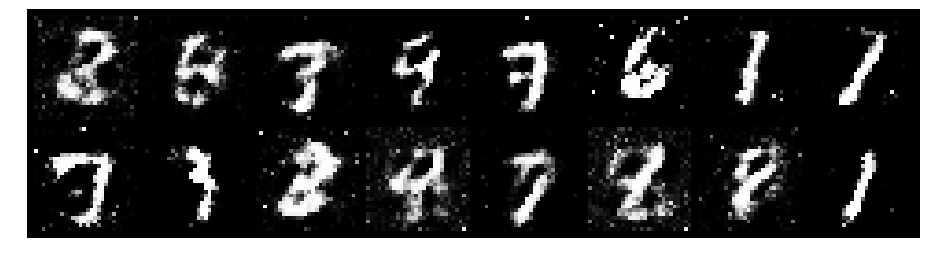

Epoch: [4/20], Batch Num: [100/600]
Discriminator Loss: 1.1012, Generator Loss: 1.1310
D(x): 0.7103, D(G(z)): 0.4247


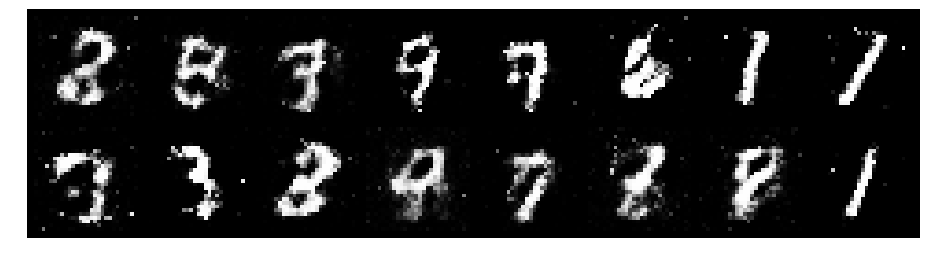

Epoch: [4/20], Batch Num: [200/600]
Discriminator Loss: 0.9495, Generator Loss: 1.2826
D(x): 0.6879, D(G(z)): 0.3500


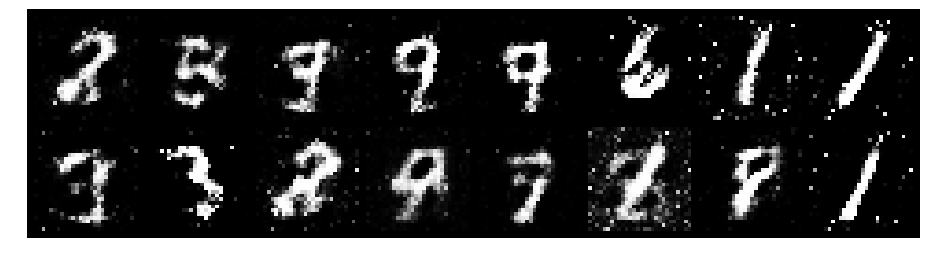

Epoch: [4/20], Batch Num: [300/600]
Discriminator Loss: 1.1600, Generator Loss: 1.4835
D(x): 0.6209, D(G(z)): 0.3556


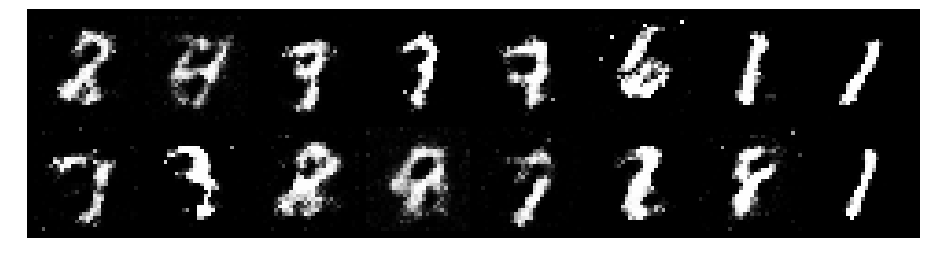

Epoch: [4/20], Batch Num: [400/600]
Discriminator Loss: 0.9873, Generator Loss: 1.8386
D(x): 0.6456, D(G(z)): 0.2749


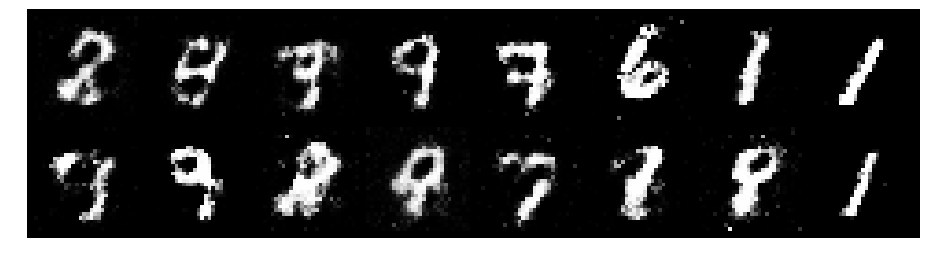

Epoch: [4/20], Batch Num: [500/600]
Discriminator Loss: 0.9381, Generator Loss: 2.2731
D(x): 0.6962, D(G(z)): 0.2859
Epoch:  6


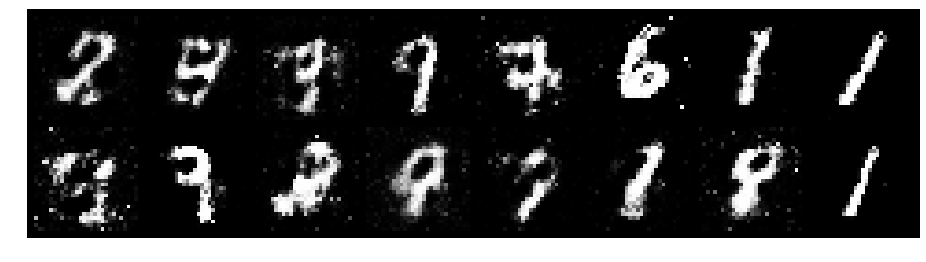

Epoch: [5/20], Batch Num: [0/600]
Discriminator Loss: 0.7712, Generator Loss: 1.9184
D(x): 0.7156, D(G(z)): 0.2286


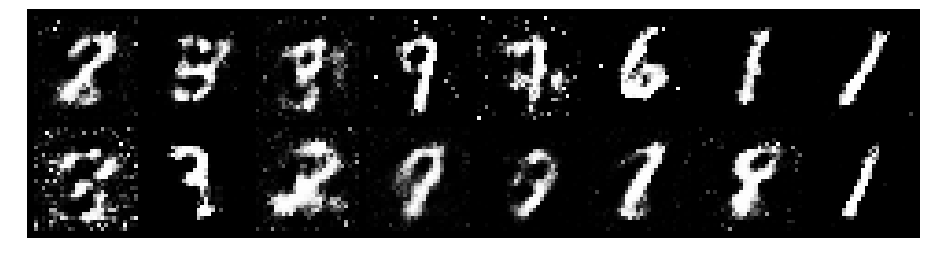

Epoch: [5/20], Batch Num: [100/600]
Discriminator Loss: 1.1405, Generator Loss: 1.3238
D(x): 0.7246, D(G(z)): 0.4330


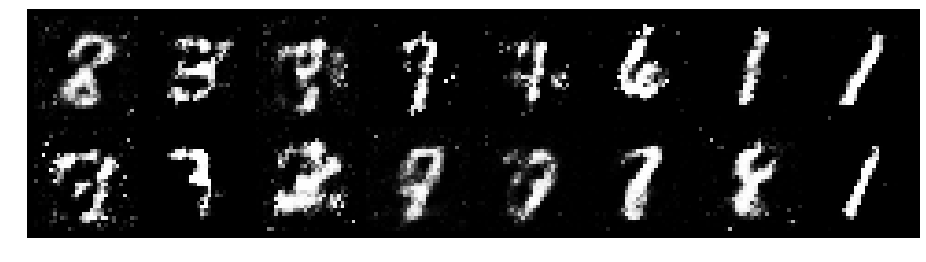

Epoch: [5/20], Batch Num: [200/600]
Discriminator Loss: 1.1196, Generator Loss: 1.3989
D(x): 0.6664, D(G(z)): 0.3939


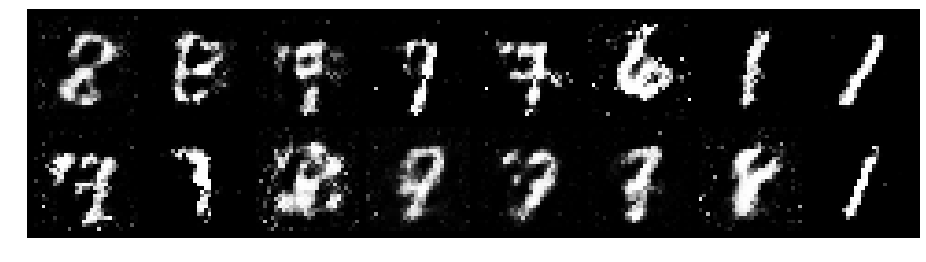

Epoch: [5/20], Batch Num: [300/600]
Discriminator Loss: 1.1879, Generator Loss: 1.1405
D(x): 0.5989, D(G(z)): 0.4069


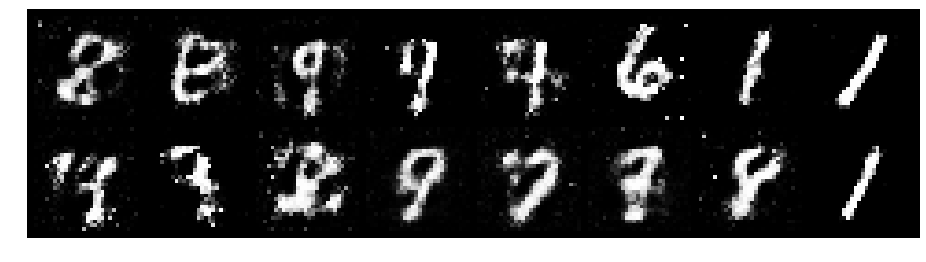

Epoch: [5/20], Batch Num: [400/600]
Discriminator Loss: 1.1630, Generator Loss: 1.1522
D(x): 0.6054, D(G(z)): 0.4106


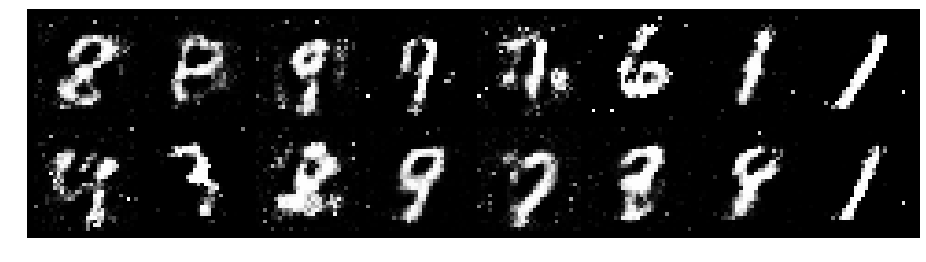

Epoch: [5/20], Batch Num: [500/600]
Discriminator Loss: 1.0946, Generator Loss: 1.5505
D(x): 0.5818, D(G(z)): 0.3028
Epoch:  7


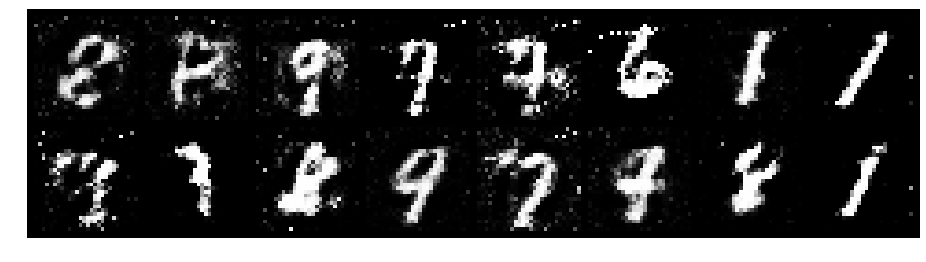

Epoch: [6/20], Batch Num: [0/600]
Discriminator Loss: 1.0482, Generator Loss: 1.4391
D(x): 0.6057, D(G(z)): 0.3161


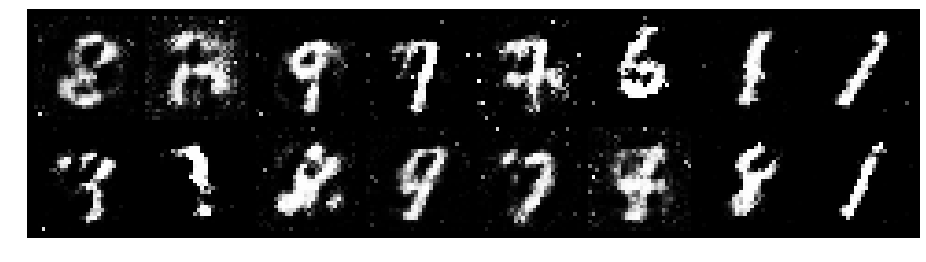

Epoch: [6/20], Batch Num: [100/600]
Discriminator Loss: 0.8652, Generator Loss: 1.5870
D(x): 0.6884, D(G(z)): 0.2851


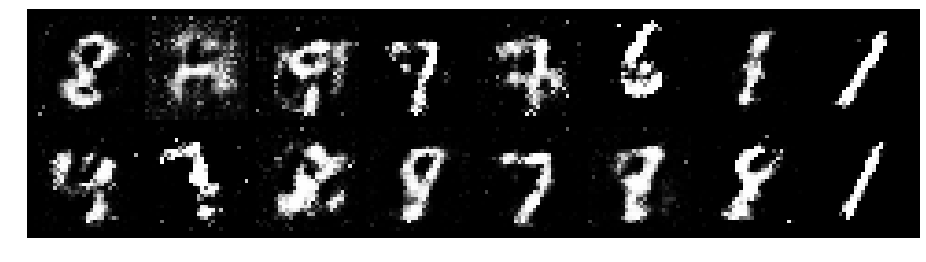

Epoch: [6/20], Batch Num: [200/600]
Discriminator Loss: 1.0267, Generator Loss: 1.5076
D(x): 0.6448, D(G(z)): 0.3260


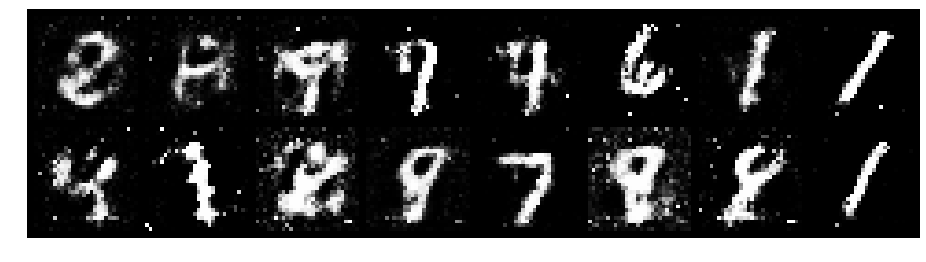

Epoch: [6/20], Batch Num: [300/600]
Discriminator Loss: 0.8042, Generator Loss: 1.9166
D(x): 0.7167, D(G(z)): 0.2693


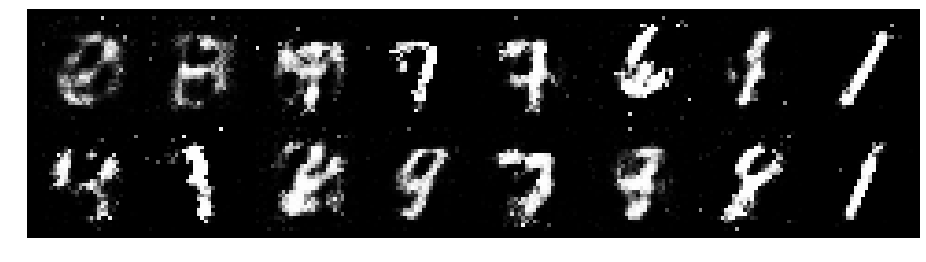

Epoch: [6/20], Batch Num: [400/600]
Discriminator Loss: 0.9586, Generator Loss: 1.3020
D(x): 0.6633, D(G(z)): 0.3098


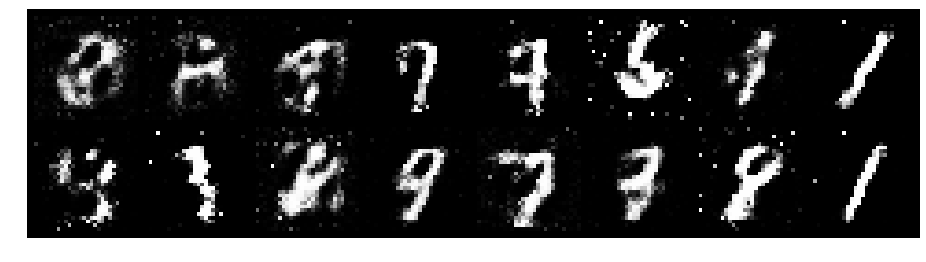

Epoch: [6/20], Batch Num: [500/600]
Discriminator Loss: 0.7764, Generator Loss: 1.3228
D(x): 0.7723, D(G(z)): 0.3338
Epoch:  8


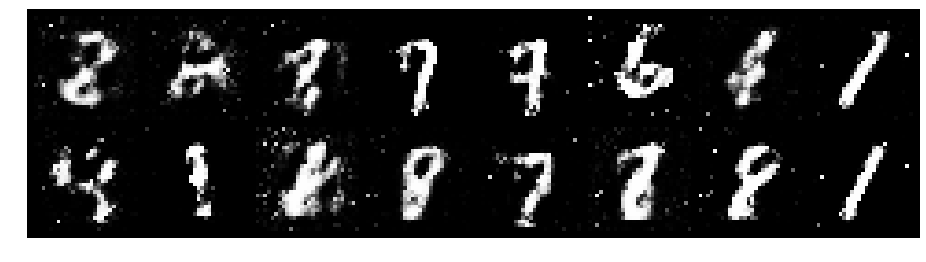

Epoch: [7/20], Batch Num: [0/600]
Discriminator Loss: 0.9410, Generator Loss: 1.4418
D(x): 0.7572, D(G(z)): 0.3713


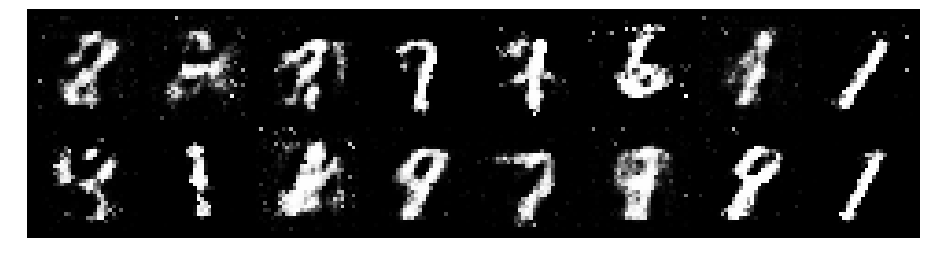

Epoch: [7/20], Batch Num: [100/600]
Discriminator Loss: 0.9238, Generator Loss: 1.2377
D(x): 0.8271, D(G(z)): 0.3939


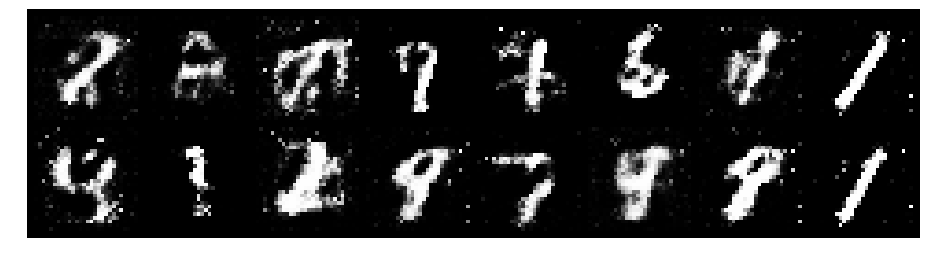

Epoch: [7/20], Batch Num: [200/600]
Discriminator Loss: 1.1930, Generator Loss: 1.4495
D(x): 0.5758, D(G(z)): 0.3337


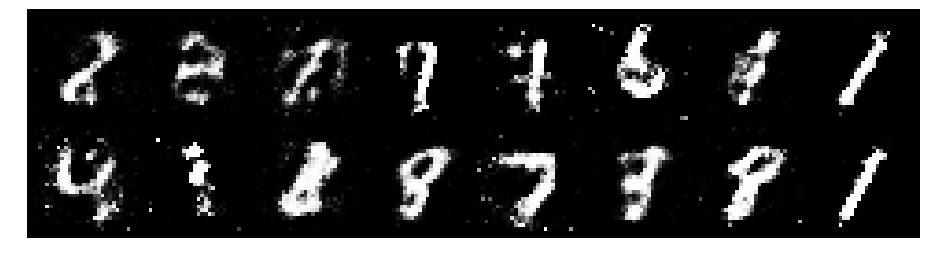

Epoch: [7/20], Batch Num: [300/600]
Discriminator Loss: 0.9640, Generator Loss: 1.8308
D(x): 0.6898, D(G(z)): 0.3125


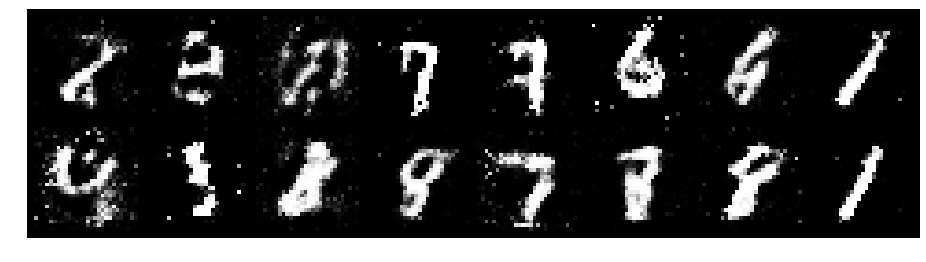

Epoch: [7/20], Batch Num: [400/600]
Discriminator Loss: 0.9473, Generator Loss: 2.0005
D(x): 0.6545, D(G(z)): 0.2537


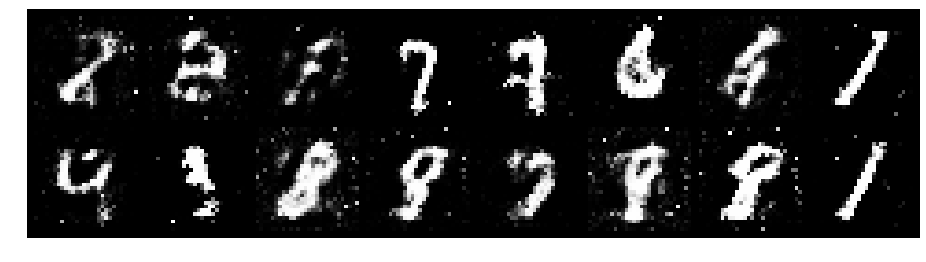

Epoch: [7/20], Batch Num: [500/600]
Discriminator Loss: 0.8933, Generator Loss: 1.6287
D(x): 0.6991, D(G(z)): 0.2889
Epoch:  9


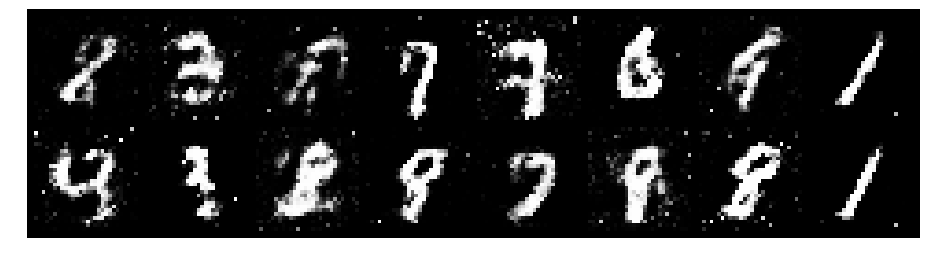

Epoch: [8/20], Batch Num: [0/600]
Discriminator Loss: 0.9064, Generator Loss: 1.6553
D(x): 0.6935, D(G(z)): 0.2995


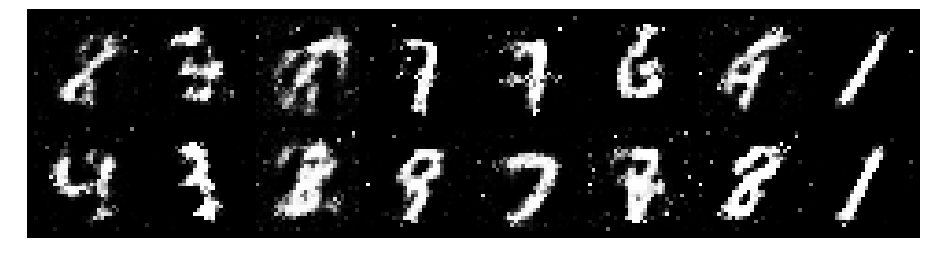

Epoch: [8/20], Batch Num: [100/600]
Discriminator Loss: 1.0073, Generator Loss: 1.3156
D(x): 0.7028, D(G(z)): 0.3669


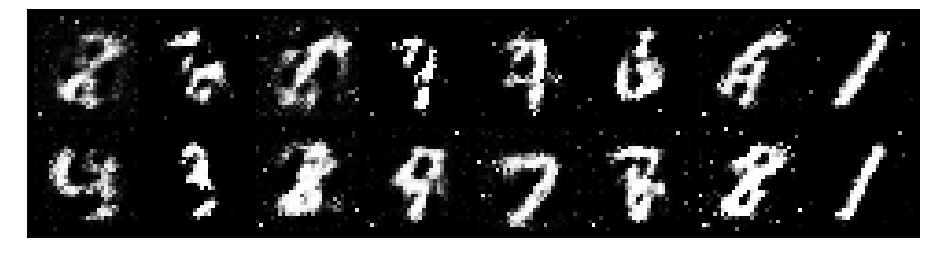

Epoch: [8/20], Batch Num: [200/600]
Discriminator Loss: 0.8715, Generator Loss: 1.4606
D(x): 0.7385, D(G(z)): 0.3325


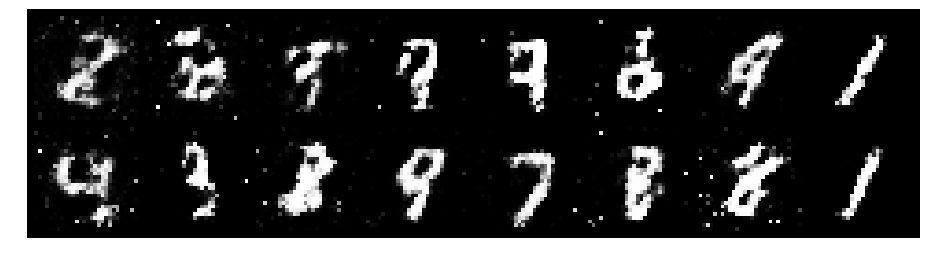

Epoch: [8/20], Batch Num: [300/600]
Discriminator Loss: 1.0884, Generator Loss: 1.7457
D(x): 0.6479, D(G(z)): 0.3322


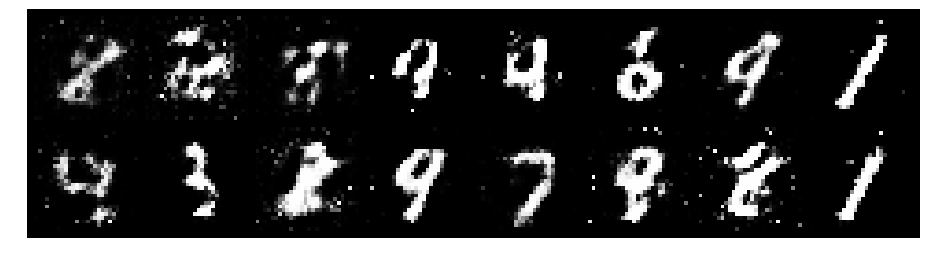

Epoch: [8/20], Batch Num: [400/600]
Discriminator Loss: 0.9747, Generator Loss: 1.4339
D(x): 0.6662, D(G(z)): 0.3082


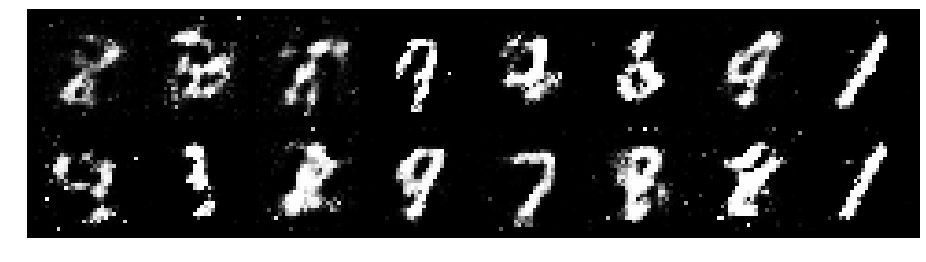

Epoch: [8/20], Batch Num: [500/600]
Discriminator Loss: 0.9472, Generator Loss: 1.4021
D(x): 0.6868, D(G(z)): 0.3098
Epoch:  10


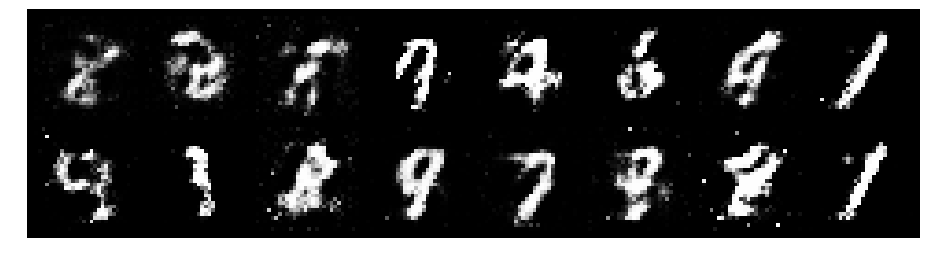

Epoch: [9/20], Batch Num: [0/600]
Discriminator Loss: 0.9209, Generator Loss: 1.3127
D(x): 0.7209, D(G(z)): 0.3579


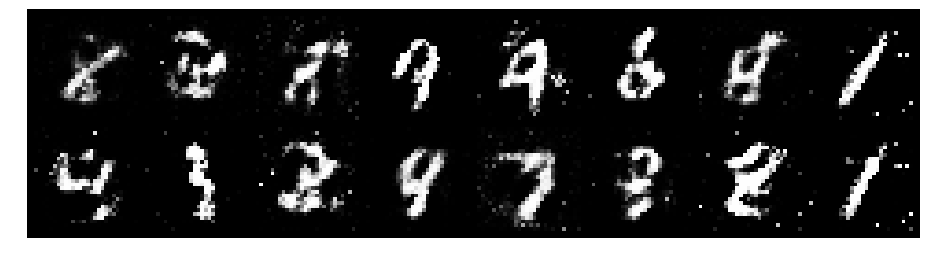

Epoch: [9/20], Batch Num: [100/600]
Discriminator Loss: 0.9108, Generator Loss: 1.9398
D(x): 0.6615, D(G(z)): 0.2814


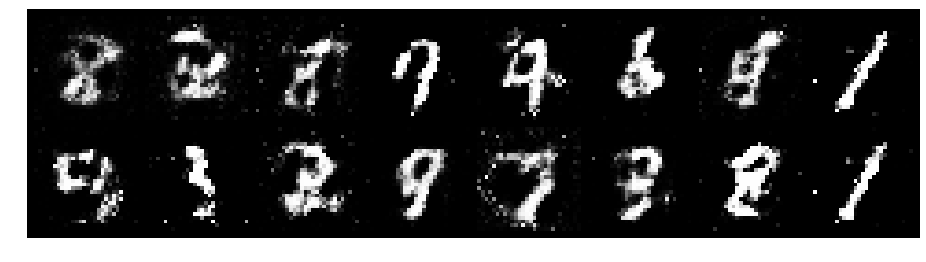

Epoch: [9/20], Batch Num: [200/600]
Discriminator Loss: 0.8484, Generator Loss: 1.5452
D(x): 0.7261, D(G(z)): 0.3135


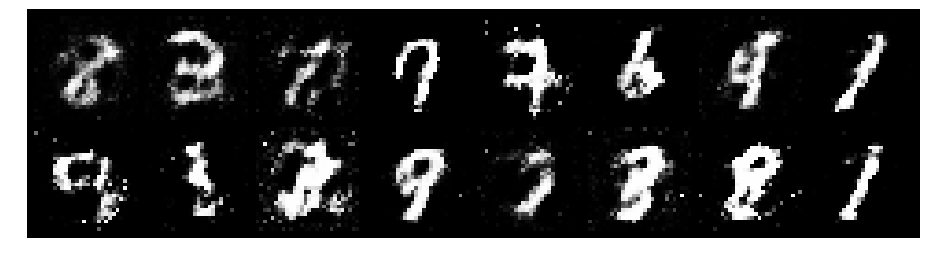

Epoch: [9/20], Batch Num: [300/600]
Discriminator Loss: 0.9723, Generator Loss: 2.1599
D(x): 0.6977, D(G(z)): 0.3353


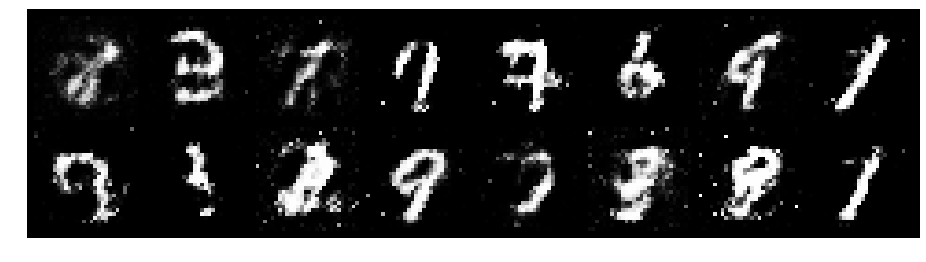

Epoch: [9/20], Batch Num: [400/600]
Discriminator Loss: 1.1671, Generator Loss: 1.4435
D(x): 0.6519, D(G(z)): 0.3767


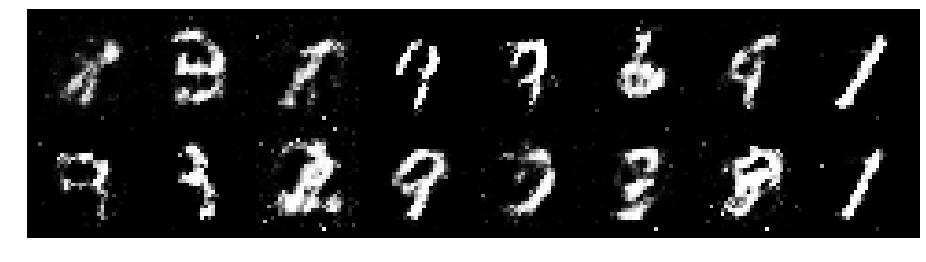

Epoch: [9/20], Batch Num: [500/600]
Discriminator Loss: 0.9725, Generator Loss: 1.2727
D(x): 0.6195, D(G(z)): 0.2980
Epoch:  11


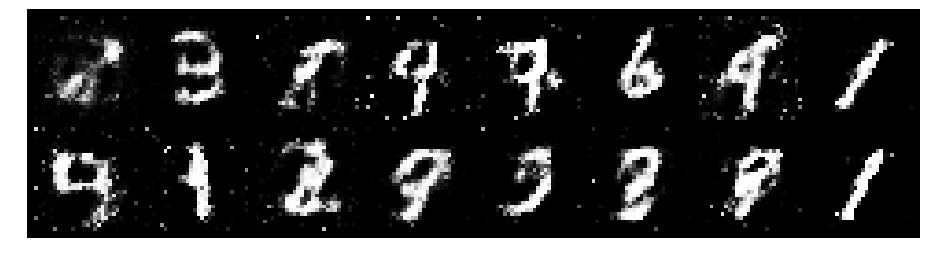

Epoch: [10/20], Batch Num: [0/600]
Discriminator Loss: 0.8307, Generator Loss: 1.7200
D(x): 0.7006, D(G(z)): 0.2628


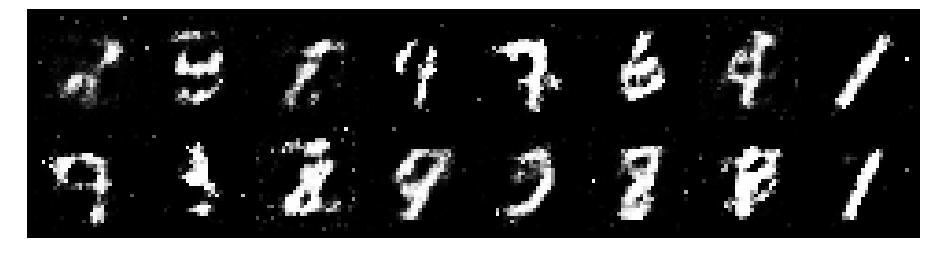

Epoch: [10/20], Batch Num: [100/600]
Discriminator Loss: 0.8791, Generator Loss: 1.3154
D(x): 0.6626, D(G(z)): 0.2728


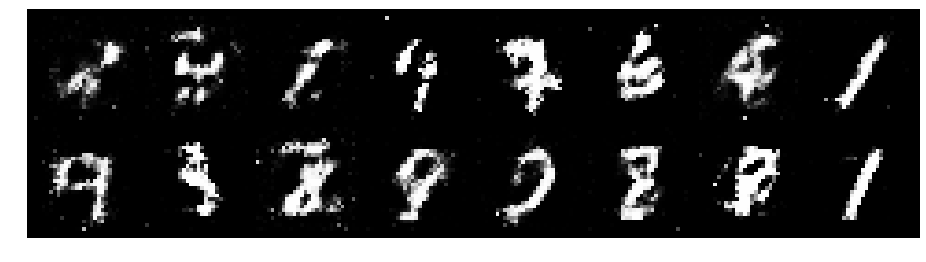

Epoch: [10/20], Batch Num: [200/600]
Discriminator Loss: 0.8520, Generator Loss: 1.7577
D(x): 0.7257, D(G(z)): 0.3142


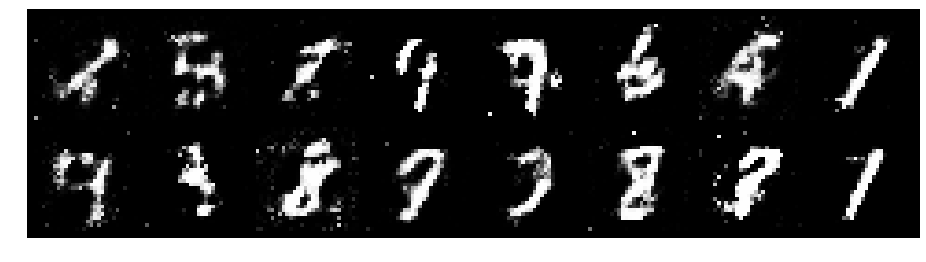

Epoch: [10/20], Batch Num: [300/600]
Discriminator Loss: 0.9329, Generator Loss: 1.4839
D(x): 0.6954, D(G(z)): 0.3343


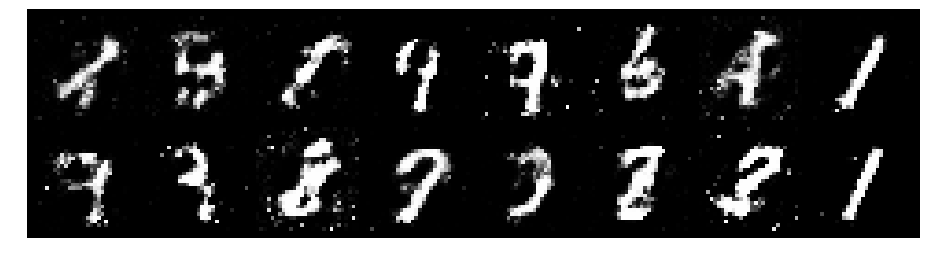

Epoch: [10/20], Batch Num: [400/600]
Discriminator Loss: 1.0425, Generator Loss: 1.3916
D(x): 0.6233, D(G(z)): 0.3191


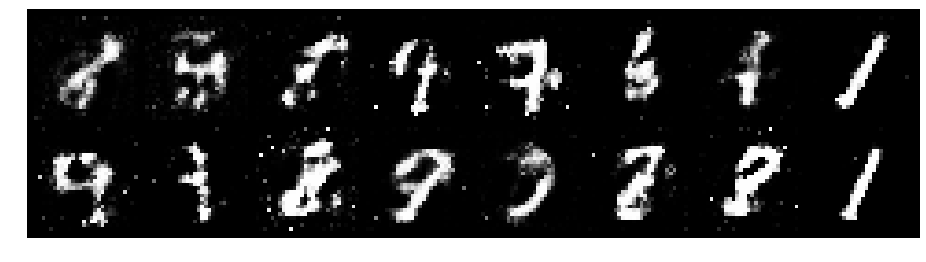

Epoch: [10/20], Batch Num: [500/600]
Discriminator Loss: 1.0151, Generator Loss: 1.5231
D(x): 0.6408, D(G(z)): 0.3071
Epoch:  12


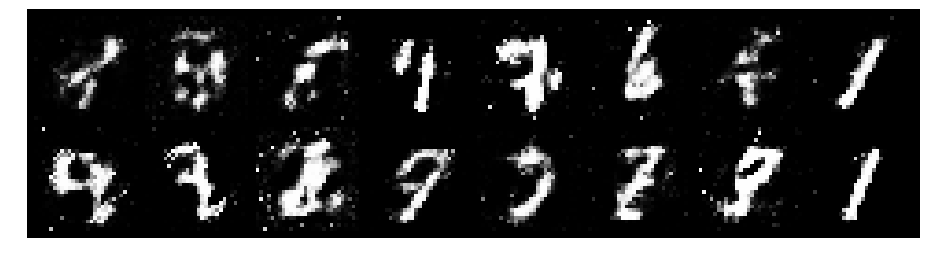

Epoch: [11/20], Batch Num: [0/600]
Discriminator Loss: 1.1243, Generator Loss: 1.2299
D(x): 0.6347, D(G(z)): 0.3903


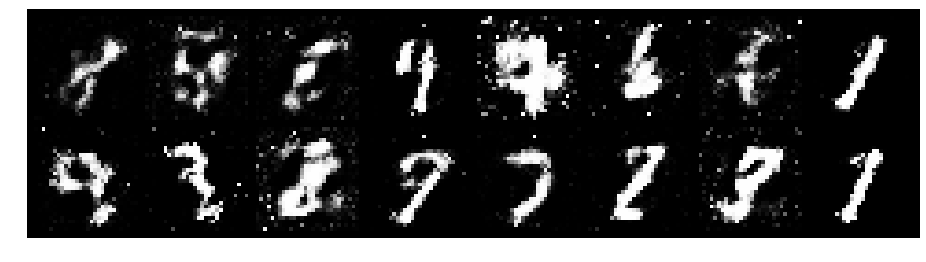

Epoch: [11/20], Batch Num: [100/600]
Discriminator Loss: 1.0410, Generator Loss: 1.2349
D(x): 0.6620, D(G(z)): 0.3285


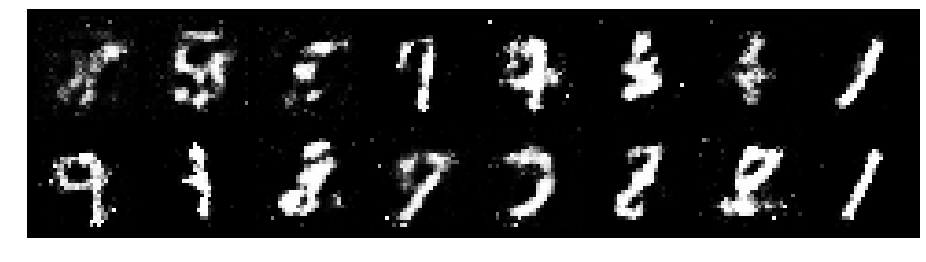

Epoch: [11/20], Batch Num: [200/600]
Discriminator Loss: 0.9066, Generator Loss: 1.6187
D(x): 0.6716, D(G(z)): 0.2762


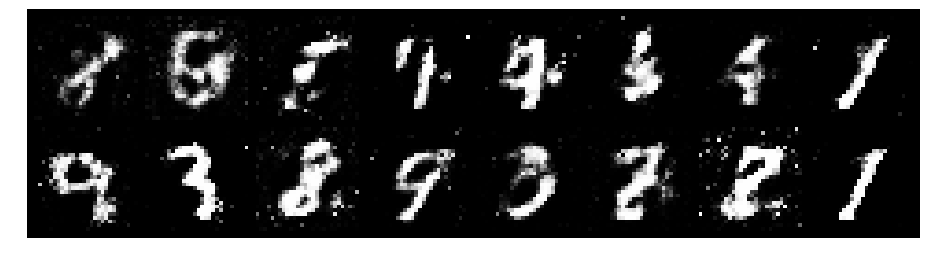

Epoch: [11/20], Batch Num: [300/600]
Discriminator Loss: 0.8940, Generator Loss: 1.7801
D(x): 0.7057, D(G(z)): 0.3039


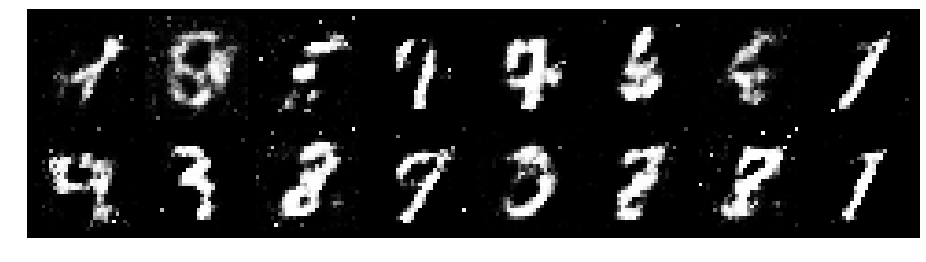

Epoch: [11/20], Batch Num: [400/600]
Discriminator Loss: 1.0129, Generator Loss: 1.6376
D(x): 0.7068, D(G(z)): 0.3359


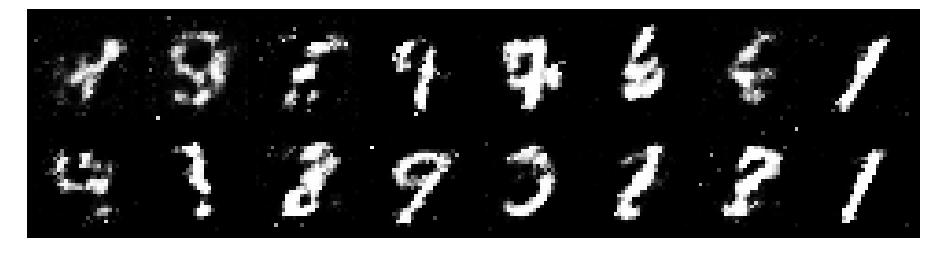

Epoch: [11/20], Batch Num: [500/600]
Discriminator Loss: 1.2202, Generator Loss: 0.9039
D(x): 0.5732, D(G(z)): 0.3543
Epoch:  13


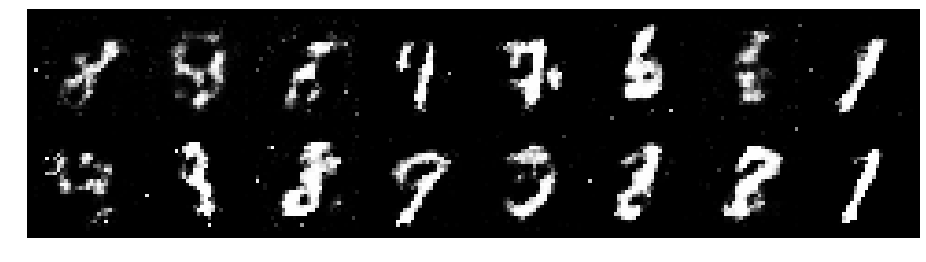

Epoch: [12/20], Batch Num: [0/600]
Discriminator Loss: 1.1150, Generator Loss: 1.3978
D(x): 0.6291, D(G(z)): 0.3579


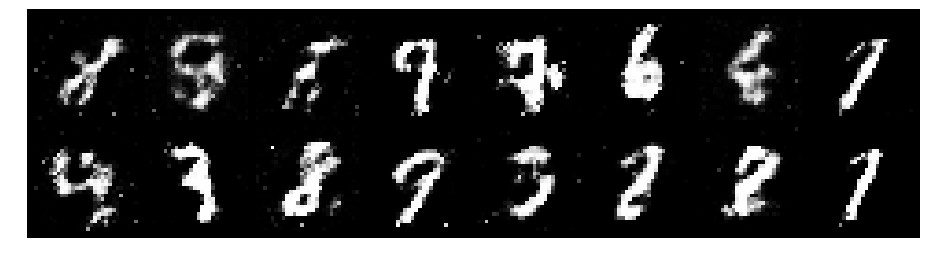

Epoch: [12/20], Batch Num: [100/600]
Discriminator Loss: 0.9576, Generator Loss: 1.4233
D(x): 0.6389, D(G(z)): 0.2857


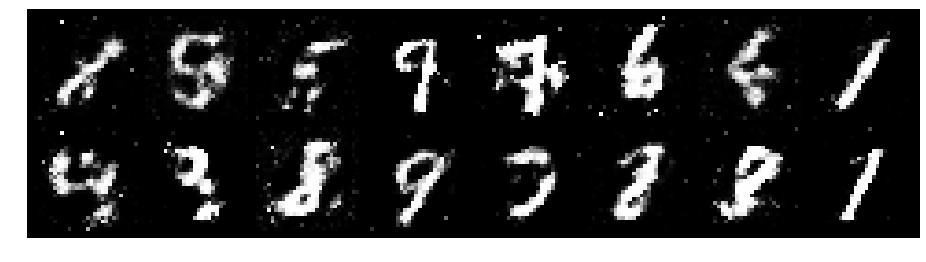

Epoch: [12/20], Batch Num: [200/600]
Discriminator Loss: 1.0687, Generator Loss: 1.4732
D(x): 0.5802, D(G(z)): 0.2407


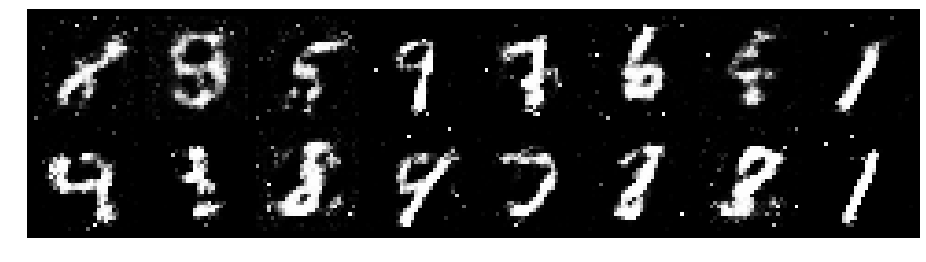

Epoch: [12/20], Batch Num: [300/600]
Discriminator Loss: 0.9746, Generator Loss: 1.3503
D(x): 0.6886, D(G(z)): 0.3829


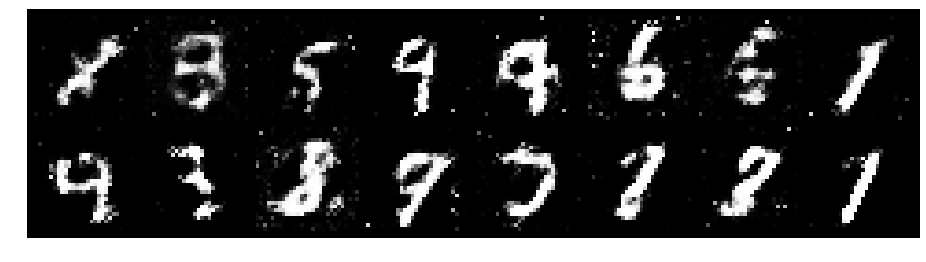

Epoch: [12/20], Batch Num: [400/600]
Discriminator Loss: 0.8701, Generator Loss: 1.7502
D(x): 0.6870, D(G(z)): 0.2785


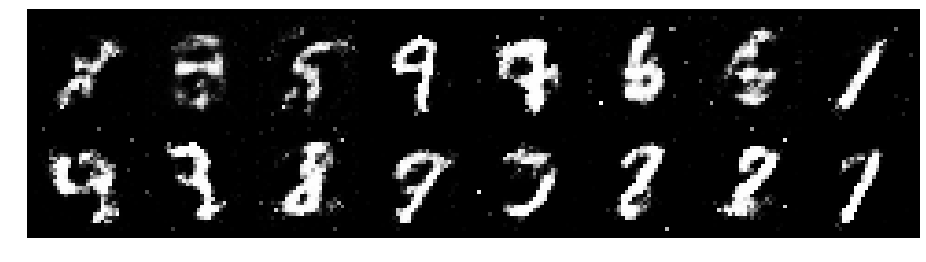

Epoch: [12/20], Batch Num: [500/600]
Discriminator Loss: 0.8640, Generator Loss: 1.5809
D(x): 0.7032, D(G(z)): 0.3101
Epoch:  14


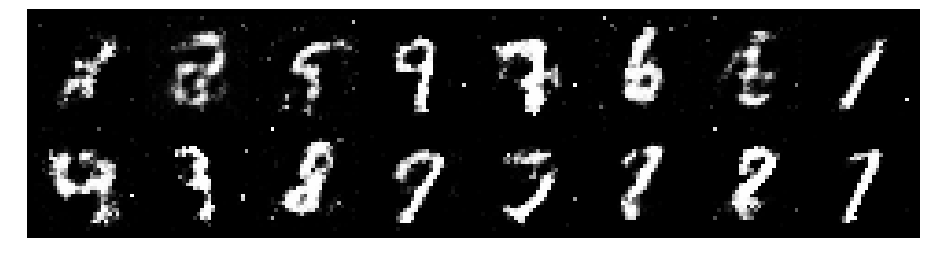

Epoch: [13/20], Batch Num: [0/600]
Discriminator Loss: 1.0658, Generator Loss: 1.6135
D(x): 0.6381, D(G(z)): 0.3045


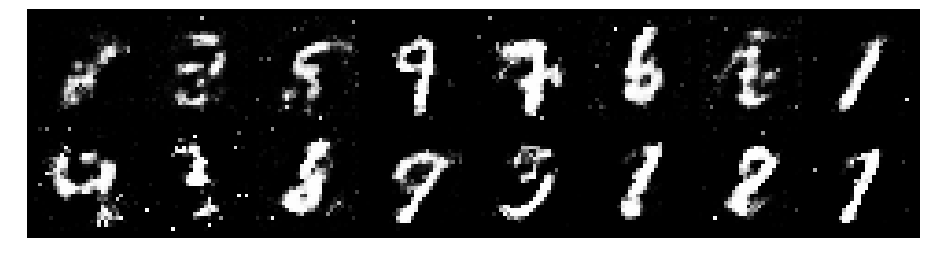

Epoch: [13/20], Batch Num: [100/600]
Discriminator Loss: 1.0819, Generator Loss: 1.7097
D(x): 0.6949, D(G(z)): 0.3472


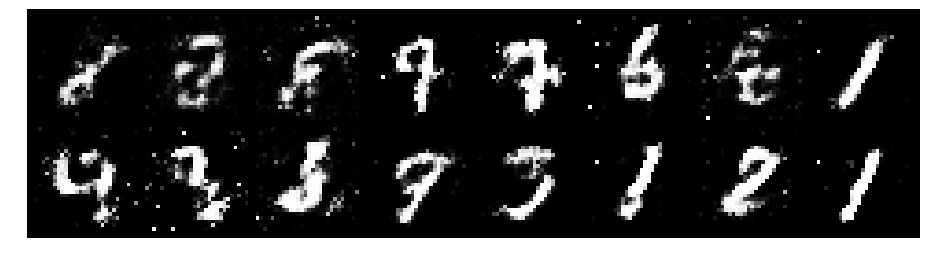

Epoch: [13/20], Batch Num: [200/600]
Discriminator Loss: 1.0901, Generator Loss: 1.5705
D(x): 0.6773, D(G(z)): 0.3912


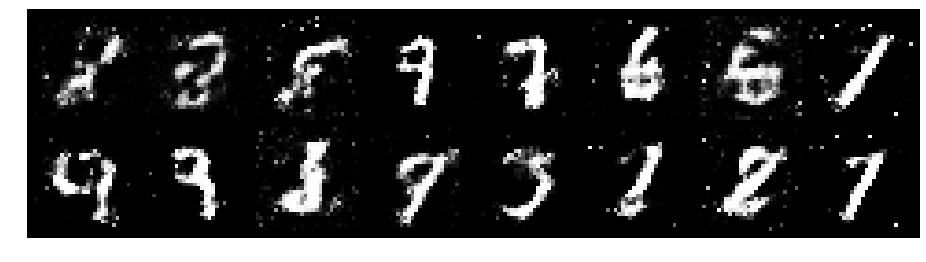

Epoch: [13/20], Batch Num: [300/600]
Discriminator Loss: 1.1156, Generator Loss: 1.1737
D(x): 0.6637, D(G(z)): 0.4037


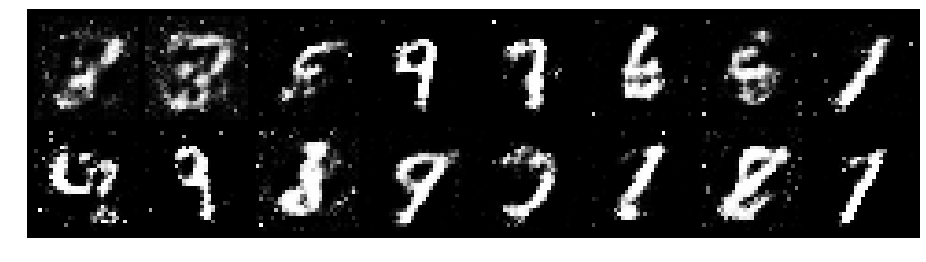

Epoch: [13/20], Batch Num: [400/600]
Discriminator Loss: 0.9873, Generator Loss: 1.2472
D(x): 0.6334, D(G(z)): 0.3318


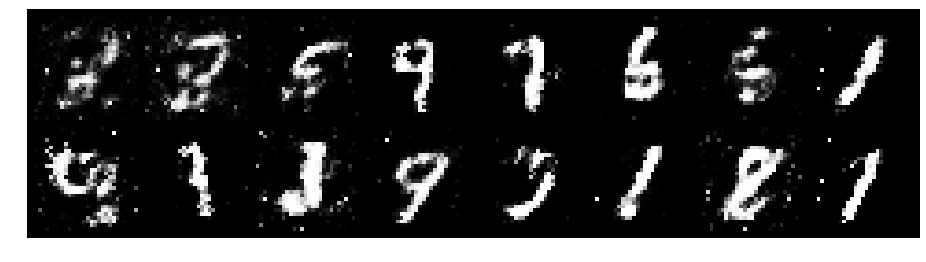

Epoch: [13/20], Batch Num: [500/600]
Discriminator Loss: 0.8487, Generator Loss: 1.5558
D(x): 0.7238, D(G(z)): 0.3177
Epoch:  15


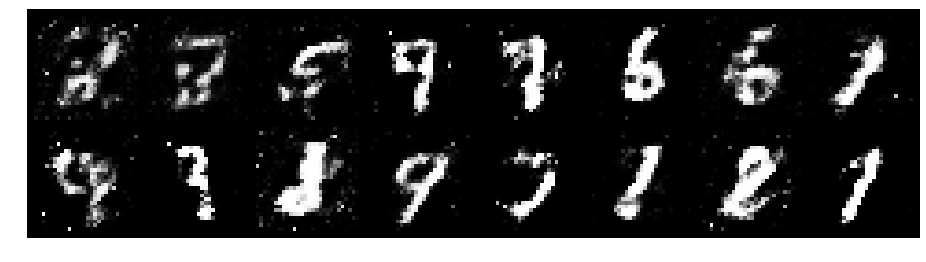

Epoch: [14/20], Batch Num: [0/600]
Discriminator Loss: 0.8783, Generator Loss: 1.7342
D(x): 0.7488, D(G(z)): 0.3356


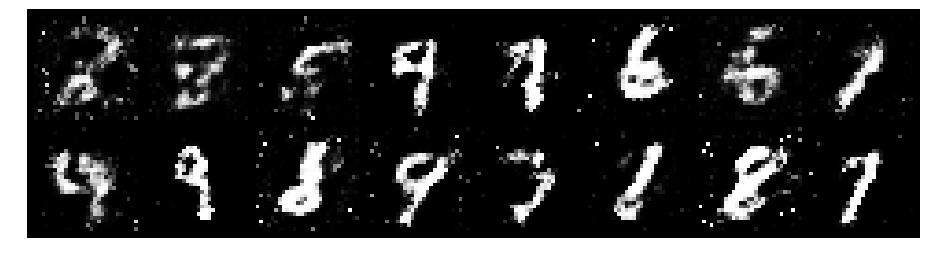

Epoch: [14/20], Batch Num: [100/600]
Discriminator Loss: 0.9072, Generator Loss: 1.1680
D(x): 0.6546, D(G(z)): 0.3255


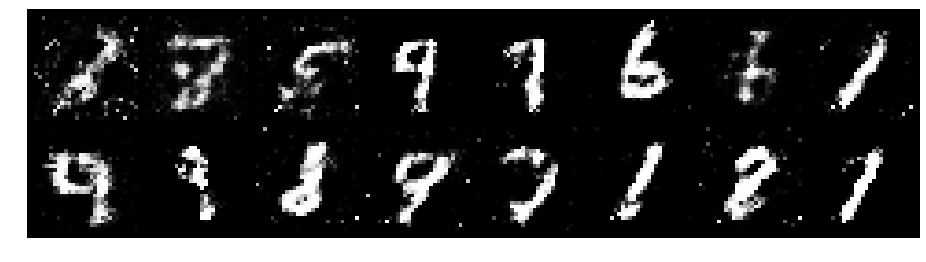

Epoch: [14/20], Batch Num: [200/600]
Discriminator Loss: 0.9980, Generator Loss: 1.4408
D(x): 0.6766, D(G(z)): 0.3670


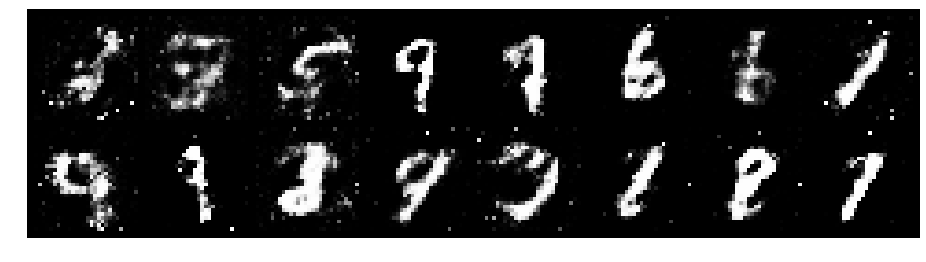

Epoch: [14/20], Batch Num: [300/600]
Discriminator Loss: 1.0315, Generator Loss: 1.3430
D(x): 0.5978, D(G(z)): 0.3259


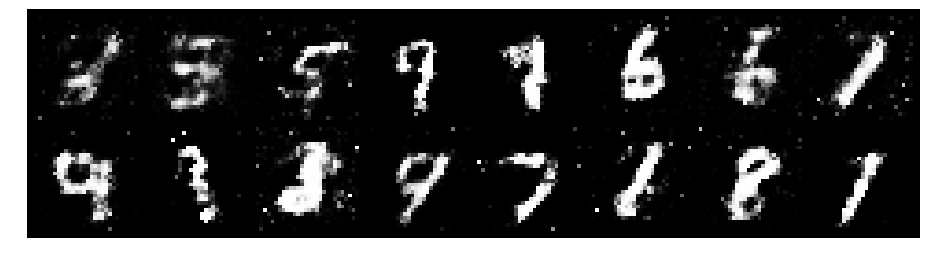

Epoch: [14/20], Batch Num: [400/600]
Discriminator Loss: 1.0567, Generator Loss: 1.6491
D(x): 0.6607, D(G(z)): 0.3560


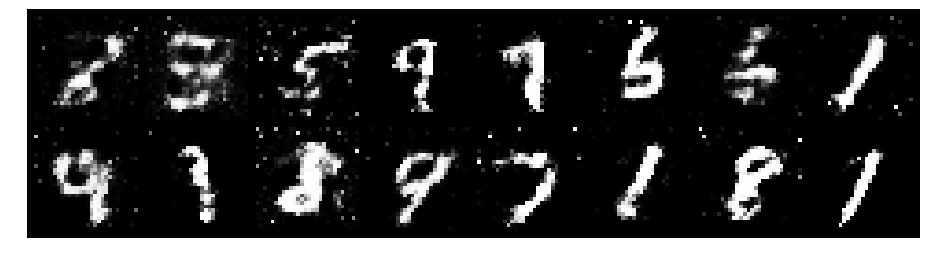

Epoch: [14/20], Batch Num: [500/600]
Discriminator Loss: 0.9611, Generator Loss: 1.4992
D(x): 0.6598, D(G(z)): 0.3263
Epoch:  16


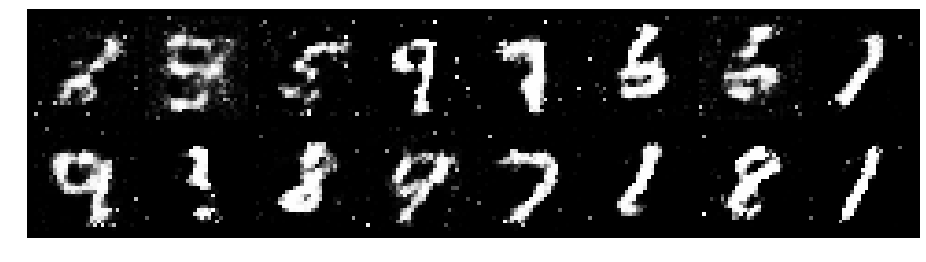

Epoch: [15/20], Batch Num: [0/600]
Discriminator Loss: 1.0806, Generator Loss: 1.1213
D(x): 0.6427, D(G(z)): 0.3659


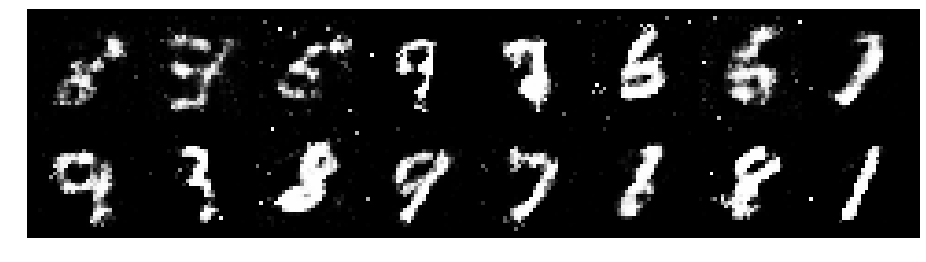

Epoch: [15/20], Batch Num: [100/600]
Discriminator Loss: 1.0472, Generator Loss: 1.0418
D(x): 0.7095, D(G(z)): 0.4273


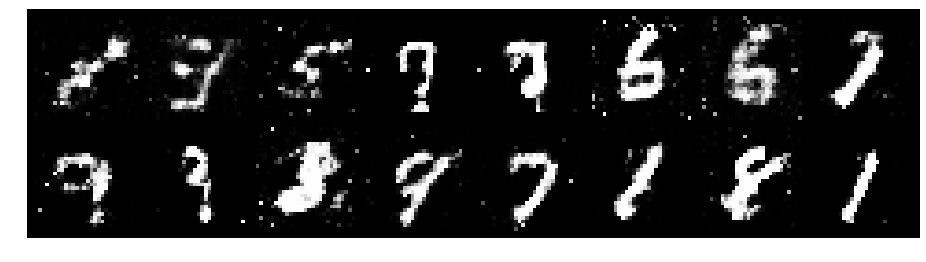

Epoch: [15/20], Batch Num: [200/600]
Discriminator Loss: 1.0329, Generator Loss: 1.1412
D(x): 0.6439, D(G(z)): 0.3741


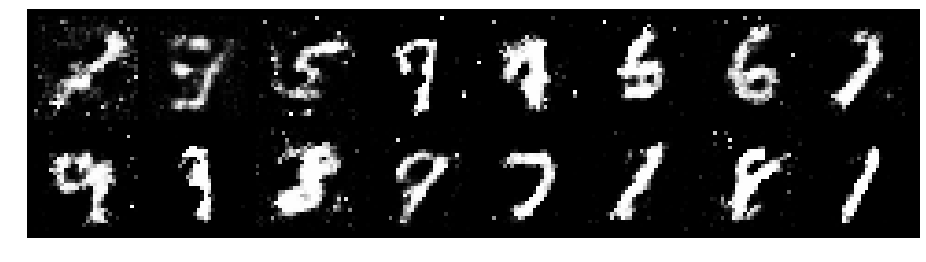

Epoch: [15/20], Batch Num: [300/600]
Discriminator Loss: 1.0615, Generator Loss: 1.3580
D(x): 0.6061, D(G(z)): 0.3391


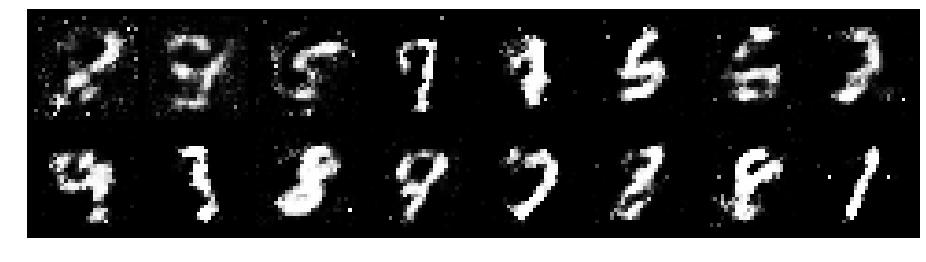

Epoch: [15/20], Batch Num: [400/600]
Discriminator Loss: 1.0000, Generator Loss: 1.2869
D(x): 0.7021, D(G(z)): 0.3578


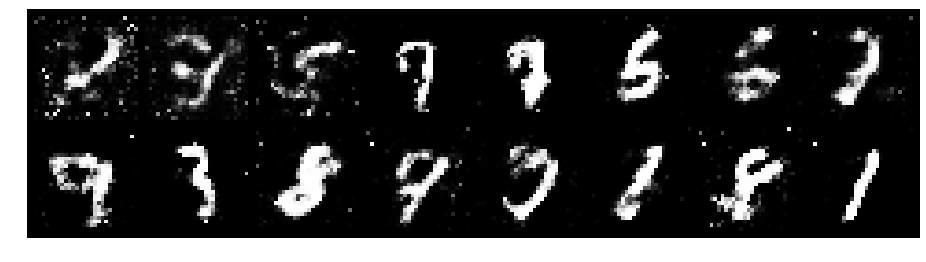

Epoch: [15/20], Batch Num: [500/600]
Discriminator Loss: 1.0898, Generator Loss: 1.0841
D(x): 0.6303, D(G(z)): 0.3704
Epoch:  17


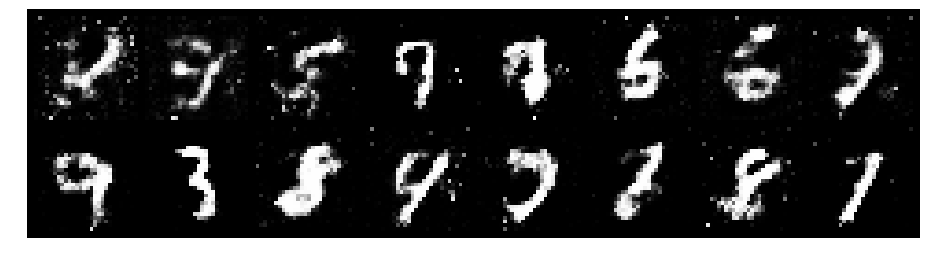

Epoch: [16/20], Batch Num: [0/600]
Discriminator Loss: 1.0037, Generator Loss: 1.3905
D(x): 0.7254, D(G(z)): 0.3749


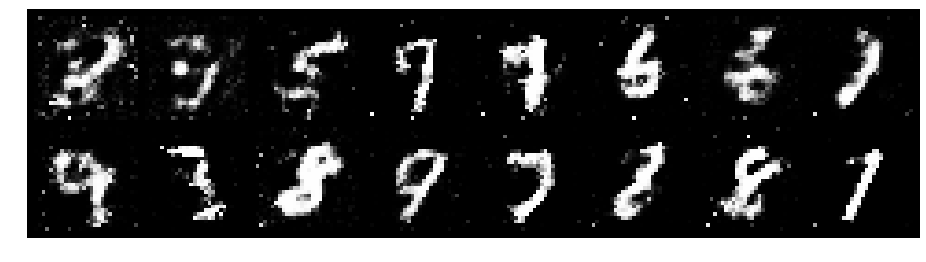

Epoch: [16/20], Batch Num: [100/600]
Discriminator Loss: 0.9231, Generator Loss: 1.9567
D(x): 0.6454, D(G(z)): 0.2840


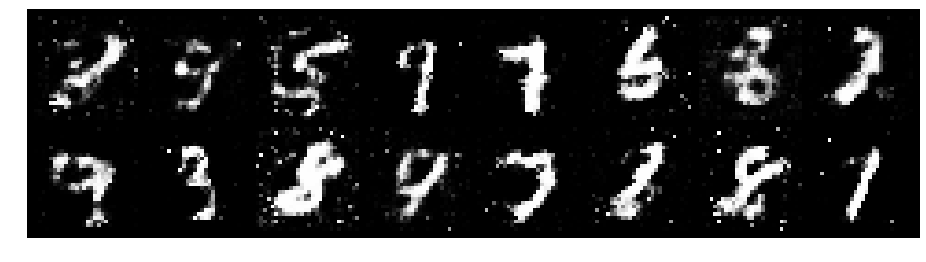

Epoch: [16/20], Batch Num: [200/600]
Discriminator Loss: 0.9675, Generator Loss: 1.4623
D(x): 0.7234, D(G(z)): 0.3868


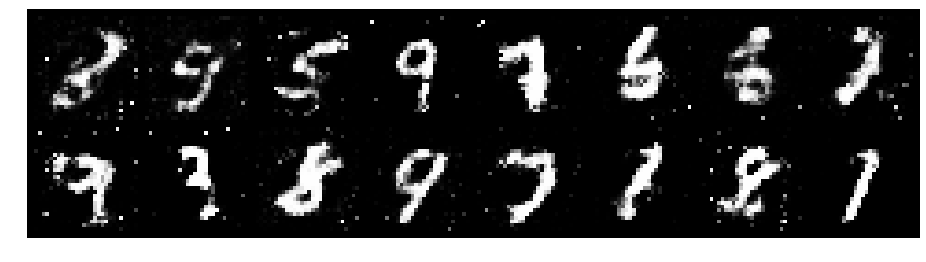

Epoch: [16/20], Batch Num: [300/600]
Discriminator Loss: 1.0718, Generator Loss: 1.3512
D(x): 0.6209, D(G(z)): 0.3596


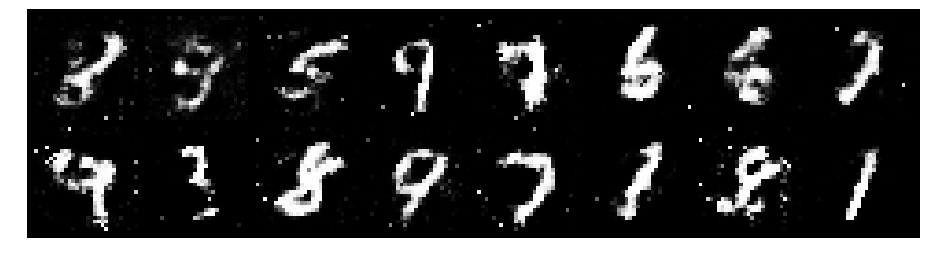

Epoch: [16/20], Batch Num: [400/600]
Discriminator Loss: 1.0139, Generator Loss: 1.2698
D(x): 0.6965, D(G(z)): 0.3875


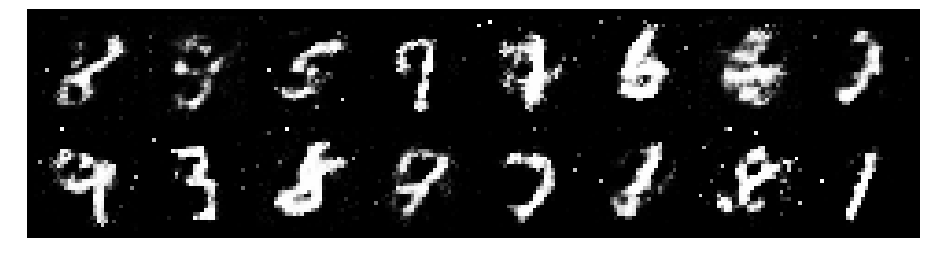

Epoch: [16/20], Batch Num: [500/600]
Discriminator Loss: 1.0864, Generator Loss: 1.3593
D(x): 0.6018, D(G(z)): 0.3289
Epoch:  18


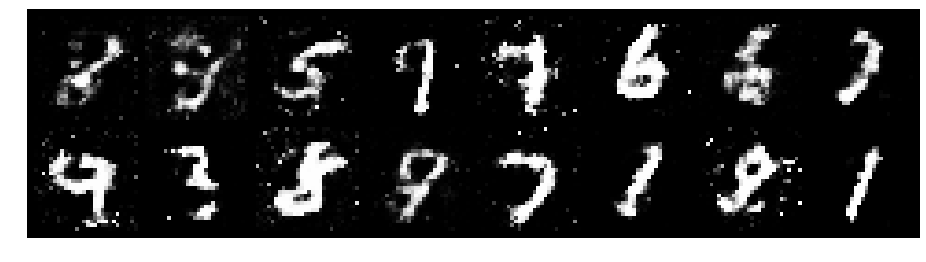

Epoch: [17/20], Batch Num: [0/600]
Discriminator Loss: 1.1520, Generator Loss: 1.0544
D(x): 0.6250, D(G(z)): 0.3902


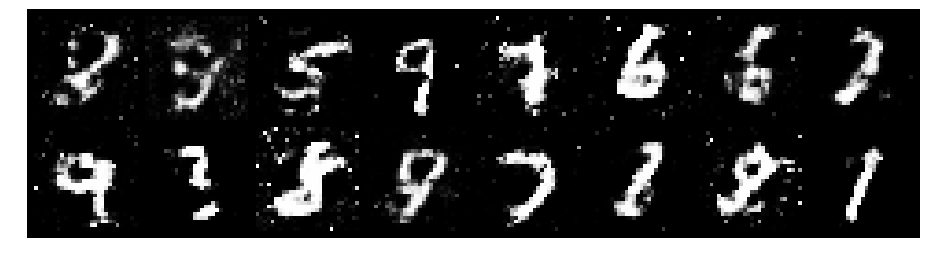

Epoch: [17/20], Batch Num: [100/600]
Discriminator Loss: 1.1447, Generator Loss: 1.2079
D(x): 0.5881, D(G(z)): 0.3105


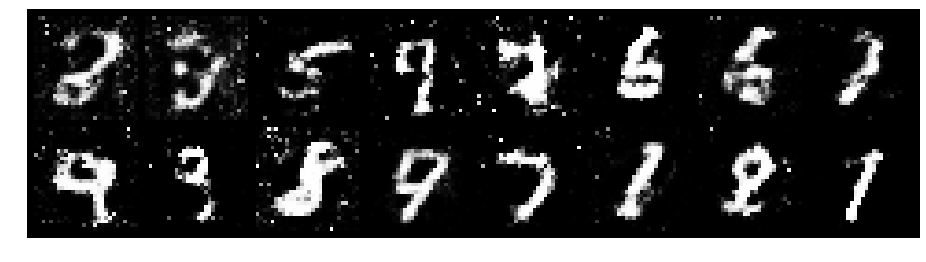

Epoch: [17/20], Batch Num: [200/600]
Discriminator Loss: 1.1209, Generator Loss: 1.0505
D(x): 0.5914, D(G(z)): 0.3814


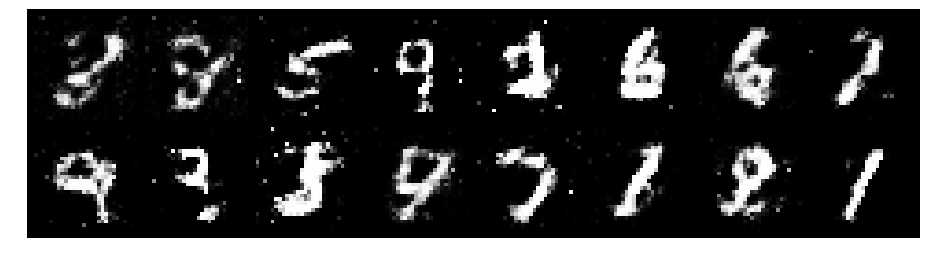

Epoch: [17/20], Batch Num: [300/600]
Discriminator Loss: 1.0321, Generator Loss: 1.1462
D(x): 0.6502, D(G(z)): 0.3786


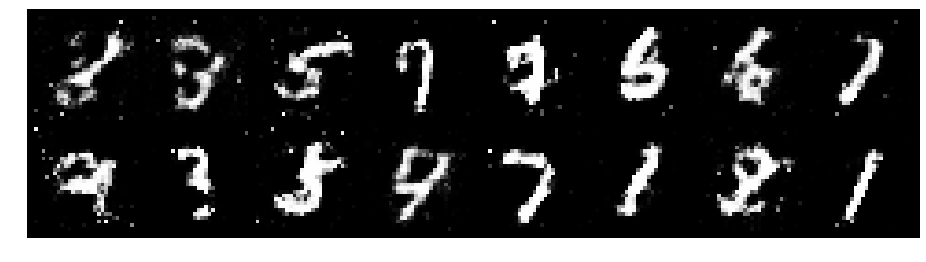

Epoch: [17/20], Batch Num: [400/600]
Discriminator Loss: 1.0165, Generator Loss: 1.1232
D(x): 0.6902, D(G(z)): 0.4129


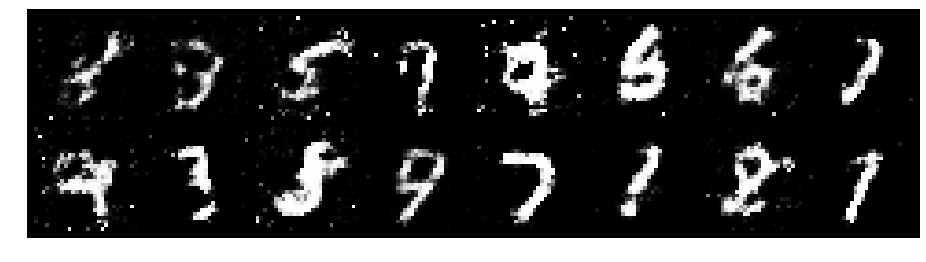

Epoch: [17/20], Batch Num: [500/600]
Discriminator Loss: 0.8917, Generator Loss: 1.3643
D(x): 0.6778, D(G(z)): 0.3276
Epoch:  19


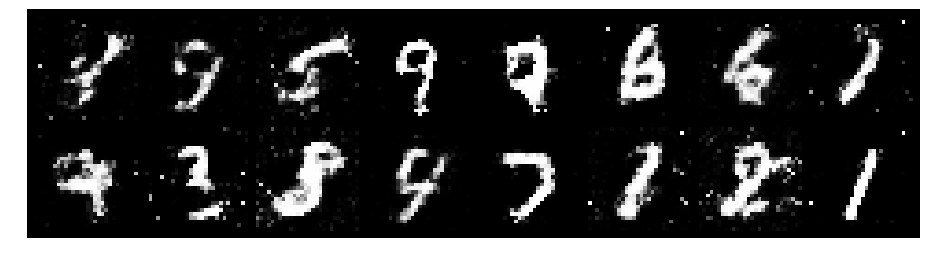

Epoch: [18/20], Batch Num: [0/600]
Discriminator Loss: 1.1197, Generator Loss: 1.2576
D(x): 0.6901, D(G(z)): 0.4268


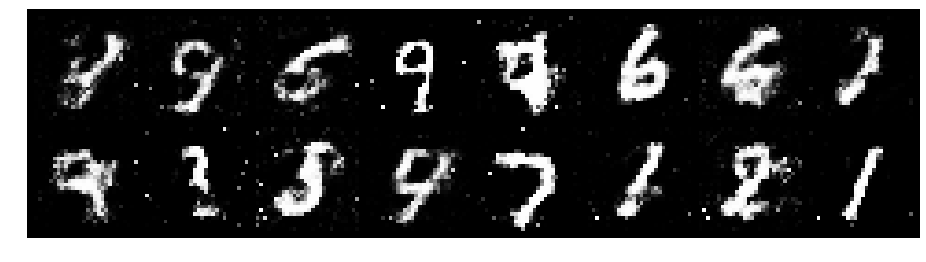

Epoch: [18/20], Batch Num: [100/600]
Discriminator Loss: 1.0902, Generator Loss: 1.1725
D(x): 0.5900, D(G(z)): 0.3621


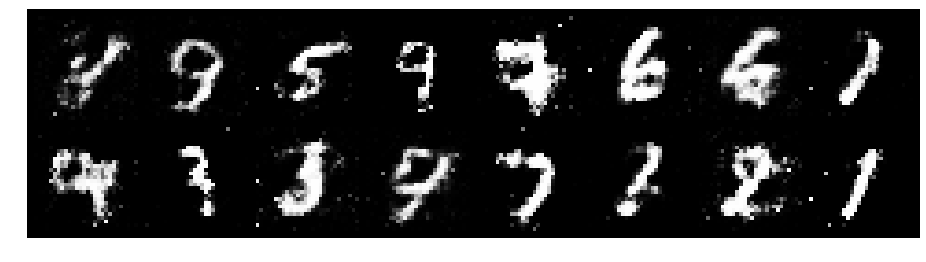

Epoch: [18/20], Batch Num: [200/600]
Discriminator Loss: 1.0436, Generator Loss: 1.4291
D(x): 0.6024, D(G(z)): 0.2959


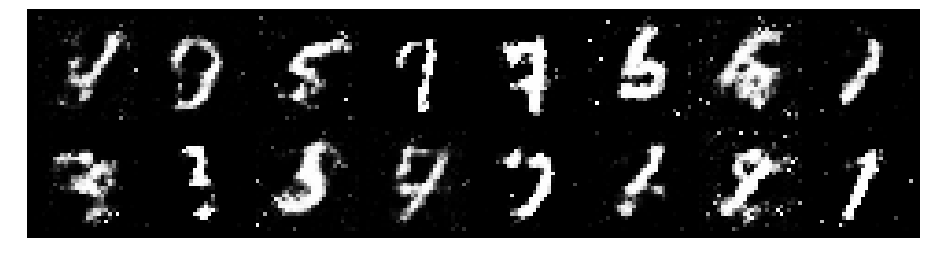

Epoch: [18/20], Batch Num: [300/600]
Discriminator Loss: 1.0707, Generator Loss: 1.7018
D(x): 0.5271, D(G(z)): 0.2288


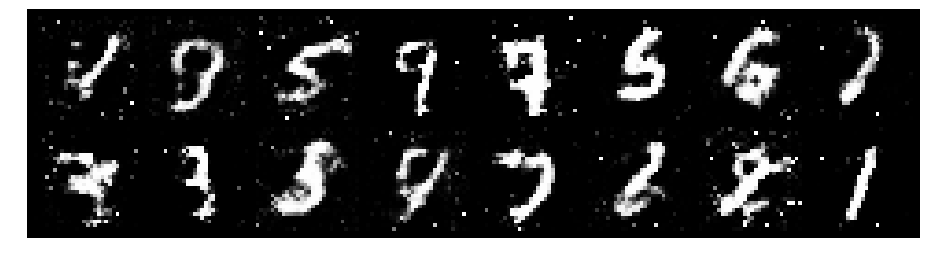

Epoch: [18/20], Batch Num: [400/600]
Discriminator Loss: 0.9138, Generator Loss: 1.3737
D(x): 0.6803, D(G(z)): 0.3257


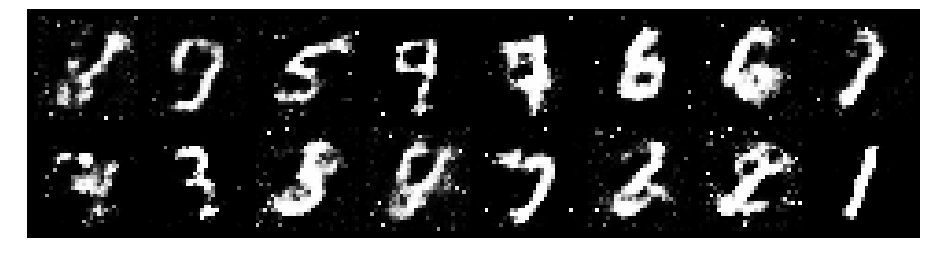

Epoch: [18/20], Batch Num: [500/600]
Discriminator Loss: 1.1089, Generator Loss: 1.2373
D(x): 0.6586, D(G(z)): 0.3937
Epoch:  20


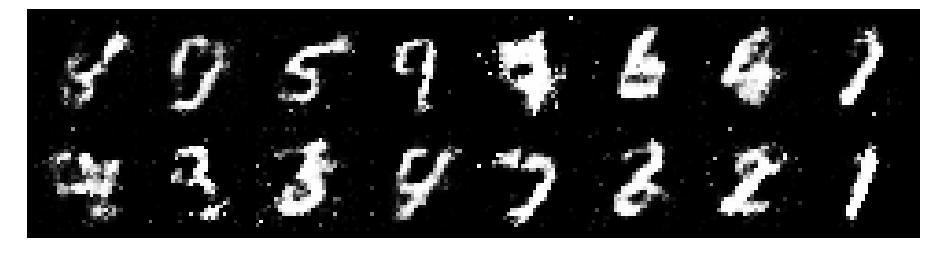

Epoch: [19/20], Batch Num: [0/600]
Discriminator Loss: 1.0739, Generator Loss: 1.1618
D(x): 0.6716, D(G(z)): 0.4103


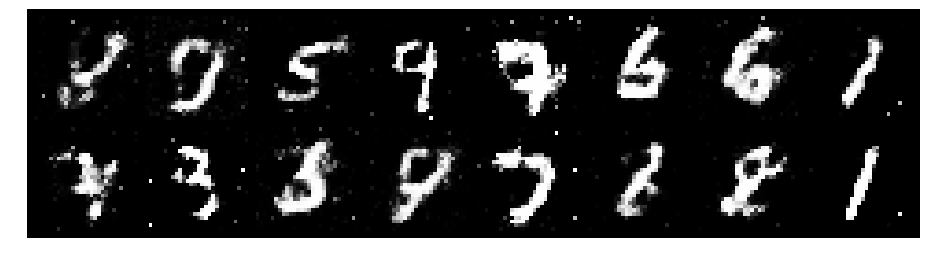

Epoch: [19/20], Batch Num: [100/600]
Discriminator Loss: 1.0781, Generator Loss: 1.2826
D(x): 0.6666, D(G(z)): 0.3978


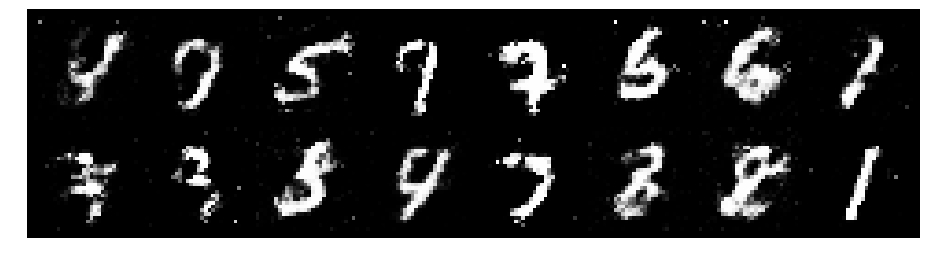

Epoch: [19/20], Batch Num: [200/600]
Discriminator Loss: 1.1820, Generator Loss: 1.5105
D(x): 0.5252, D(G(z)): 0.3050


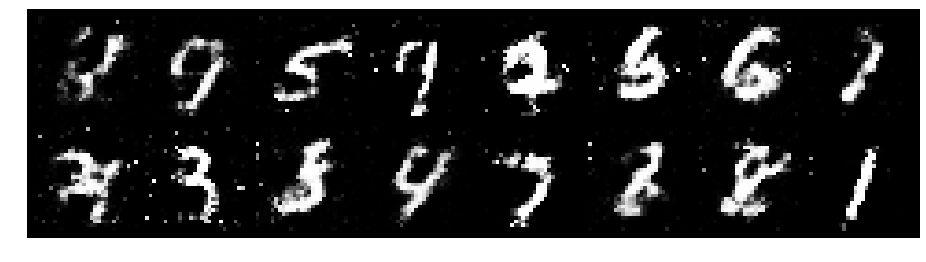

Epoch: [19/20], Batch Num: [300/600]
Discriminator Loss: 1.0444, Generator Loss: 1.4140
D(x): 0.6421, D(G(z)): 0.3557


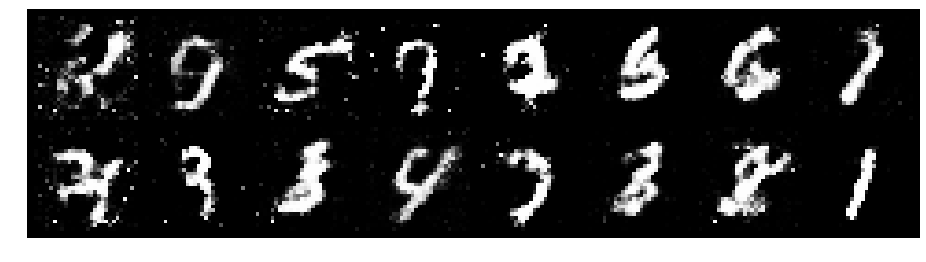

Epoch: [19/20], Batch Num: [400/600]
Discriminator Loss: 1.1914, Generator Loss: 1.2824
D(x): 0.6177, D(G(z)): 0.3982


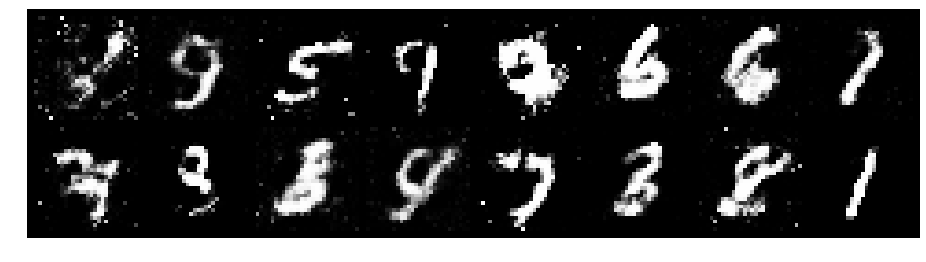

Epoch: [19/20], Batch Num: [500/600]
Discriminator Loss: 1.0413, Generator Loss: 1.1194
D(x): 0.6544, D(G(z)): 0.4029
Wall time: 30min 45s


In [67]:
%%time

# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')

# Total number of epochs to train
num_epochs = 20

for epoch in range(num_epochs):
    print("Epoch: ", epoch+1)
    for n_batch, (real_batch,_) in enumerate(data_loader):
        
        N = real_batch.size(0)
        
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        
        # Generate fake data
        fake_data = generator(noise(N))
        
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch+1, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

# Keras GAN

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [4]:
# Let Keras know that we are using tensorflow as our backend engine
os.environ["KERAS_BACKEND"] = "tensorflow"

# To make sure that we can reproduce the experiment and get the same results
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100

In [5]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [6]:
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [7]:
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [8]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [9]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [10]:
# Create a wall of generated MNIST images
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

--------------- Epoch 1 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:32<00:00,  2.78it/s]


--------------- Epoch 2 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:21<00:00,  3.00it/s]


--------------- Epoch 3 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:23<00:00,  2.91it/s]


--------------- Epoch 4 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:38<00:00,  2.71it/s]


--------------- Epoch 5 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:28<00:00,  2.62it/s]


--------------- Epoch 6 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:34<00:00,  2.99it/s]


--------------- Epoch 7 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:42<00:00,  2.50it/s]


--------------- Epoch 8 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:34<00:00,  2.67it/s]


--------------- Epoch 9 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:40<00:00,  2.56it/s]


--------------- Epoch 10 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:40<00:00,  2.26it/s]


--------------- Epoch 11 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:24<00:00,  3.03it/s]


--------------- Epoch 12 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:20<00:00,  2.69it/s]


--------------- Epoch 13 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:28<00:00,  3.07it/s]


--------------- Epoch 14 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:19<00:00,  3.02it/s]


--------------- Epoch 15 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:26<00:00,  2.18it/s]


--------------- Epoch 16 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:34<00:00,  2.61it/s]


--------------- Epoch 17 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:34<00:00,  2.64it/s]


--------------- Epoch 18 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:25<00:00,  3.06it/s]


--------------- Epoch 19 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:17<00:00,  3.05it/s]


--------------- Epoch 20 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:18<00:00,  3.04it/s]


--------------- Epoch 21 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:18<00:00,  3.06it/s]


--------------- Epoch 22 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:19<00:00,  2.93it/s]


--------------- Epoch 23 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:19<00:00,  2.93it/s]


--------------- Epoch 24 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:15<00:00,  3.12it/s]


--------------- Epoch 25 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:21<00:00,  2.85it/s]


--------------- Epoch 26 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:25<00:00,  2.94it/s]


--------------- Epoch 27 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:47<00:00,  2.16it/s]


--------------- Epoch 28 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:32<00:00,  2.56it/s]


--------------- Epoch 29 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:41<00:00,  2.23it/s]


--------------- Epoch 30 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:41<00:00,  2.36it/s]


--------------- Epoch 31 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:29<00:00,  2.40it/s]


--------------- Epoch 32 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:31<00:00,  2.83it/s]


--------------- Epoch 33 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:41<00:00,  2.11it/s]


--------------- Epoch 34 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:46<00:00,  2.34it/s]


--------------- Epoch 35 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:43<00:00,  2.11it/s]


--------------- Epoch 36 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:27<00:00,  2.95it/s]


--------------- Epoch 37 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:27<00:00,  2.36it/s]


--------------- Epoch 38 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:30<00:00,  2.30it/s]


--------------- Epoch 39 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:43<00:00,  2.20it/s]


--------------- Epoch 40 ---------------


100%|████████████████████████████████████████████████████████████████████████████████| 234/234 [01:41<00:00,  2.49it/s]


Wall time: 1h 51s


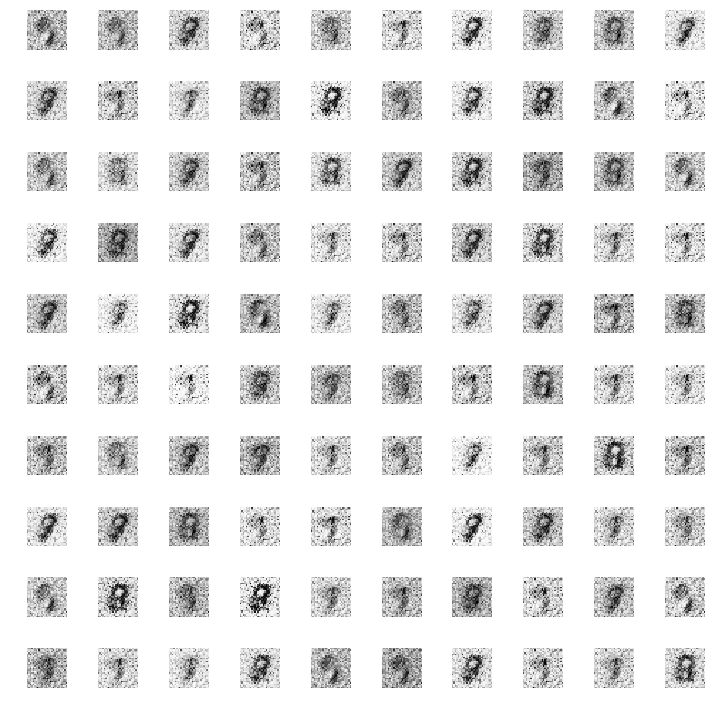

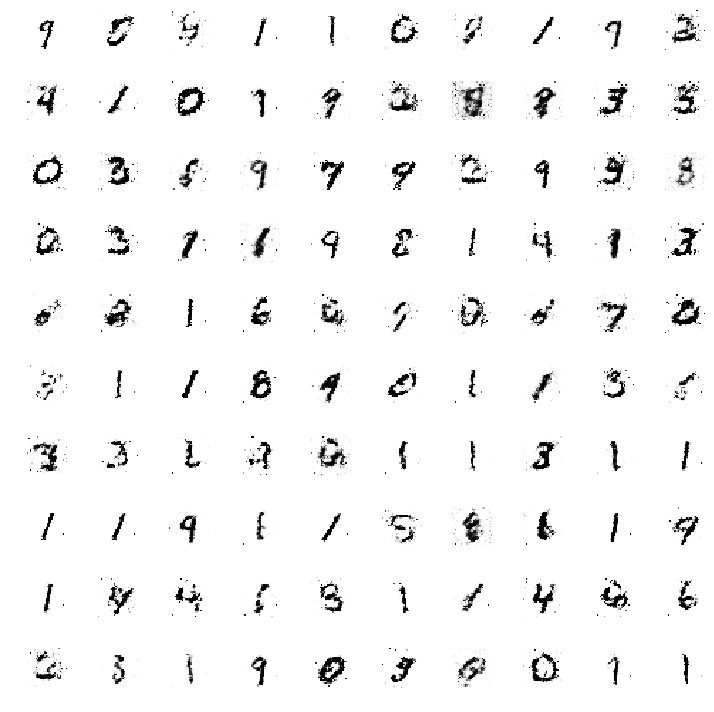

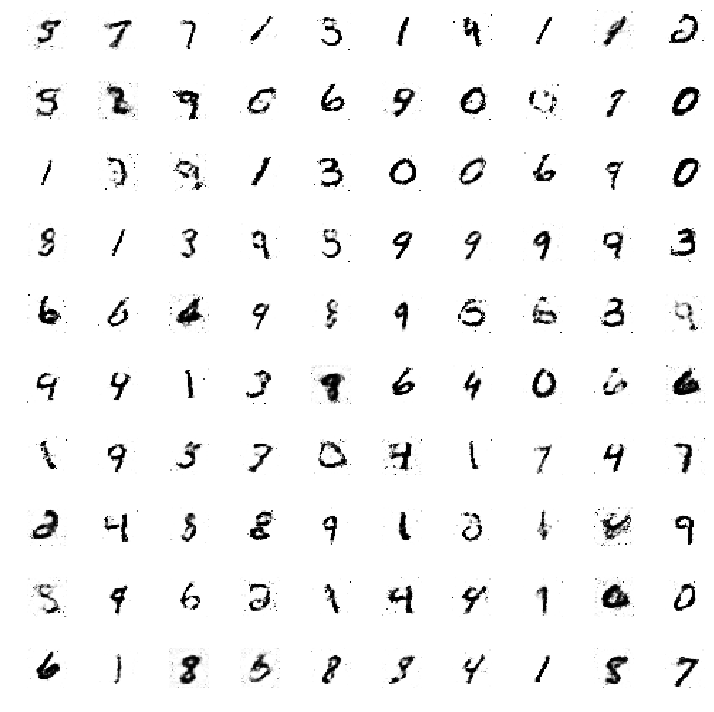

In [69]:
%%time

def train(epochs =10, batch_size =128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size

    # Build our GAN netowrk
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

if __name__ == '__main__':
    train(epochs=40, batch_size=256)